# Classification of galaxy images into two classes

In this notebook I present the results from the classification og galaxy images into two types using supervised learning. The fits are done elsewhere.
First I load the needed libraries.

In [1]:
#standard libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.cm as cm
import sys
import os
import time
import random as random
#accesing fits, file format for images and more in astronomy 
from astropy.io import fits
#deep learning and helper function from torch 
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
#sklearn helper functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score,f1_score, log_loss, ConfusionMatrixDisplay
#xgboost for comparison
from xgboost import XGBClassifier
#logistic regression for comparison 
from sklearn.linear_model import LogisticRegression
#own functions
from functions_ml import *
from functions_wcs import *
#for accesing saved models  
import pickle
#supress warnings, which dont matter
import warnings
warnings.filterwarnings('ignore')

## Data introduction and preparation

The data consist of two pieces. Firstly, images, which were saved as 4 dimensions (1 dimension x of image, secondly of image, third channels, forth image in order or batch in torch language) numpy arrays, because torch needs 4d arrays, even when only a single channel exists as we see here in this example. The images are from an SDSS survey which surveyed most of the northern sky. A subset, stripe 82, is imaged several times and is of better quality therefor I use it in its entirety. The images are from http://research.iac.es/proyecto/stripe82/pages/data.php I use the rdeep channel because that is the channel (combination) with the highest signal to noise ratio. Only a limited size around each galaxy center is saved. This size is derived from the largest typical size of a galaxy on a subset of the data. This still does not mean that nothing of the galaxy is missed that way because galaxies do not have sharp borders. Some is likely often missed. However, on the other hand a cutout that is too large gets more from other sources, thus very large is also not ideal. The size likely impacts the results, but investigating the impact of size is beyond the scope of this notebook.

Secondly, information on each image is loaded from csv files into data frames. The most important information in the csv files are the classes spiral and elliptical which are bolean and exclusive here. There are also citizen zoo classifications from the zoo project. They are published in https://ui.adsabs.harvard.edu/abs/2011MNRAS.410..166L/abstract Here I use only certain spiral/elliptical data frams, but there is not 100% certainty because galaxies can be in transition between these two classes. Furthermore, this classification is done by different citizen scientists and thus depends on how each chose to classify different images.

Below I collect the data, which is produced by the program get_zoo_galaxies.py. This program is applied 43 times. This way it gets data from 43 fields. These fields cover the area from 310 (-50) degree to 60 degree in right ascension with a height from -1.26 to +1.26 degree in declination. This way I get all of stripe 82.

In [2]:
#getting the list of images
myPath='/home/tobias/ml-testing/astr-images'
list_images=[f for f in os.listdir(myPath) 
    if f.endswith('_ell_spiral_im.npy') ]
list_images.sort()
#getting the list of tables 
list_tables=[f for f in os.listdir(myPath) 
    if f.endswith('_ell_spiral_table.csv')]
list_tables.sort()

I combine the images and the data frames here into a single file each. 

In [3]:
#images
cutouts=comb_nump_4d(list_images)
#dataframes 
list_df=[]
for i in range(len(list_tables)):
    i=pd.read_csv(list_tables[i])
    list_df.append(i)  
print(f"number of tables is {len(list_df)}") 
df=pd.concat(list_df,ignore_index=True)
print(f"shape of combined data frame {df.shape}")
print(f"shape of image file is {cutouts.shape}")

number of tables is 43
shape of combined data frame (7875, 51)
shape of image file is (43, 43, 1, 7875)


The images and the classification data have the same lengths as they should. Now I am looking on the classes.


In [4]:
print(df.spiral.value_counts())

1    5766
0    2109
Name: spiral, dtype: int64


The classes are somewhat imbalanced, there more spirals than not spirals. Since the classes are exclusive the not spirals are elliptical galaxies. 

Next I display some examples for each class.

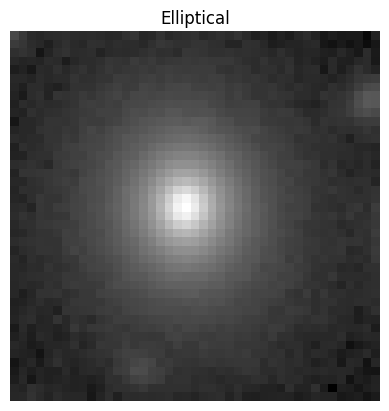

In [5]:
x=0
plt.axis('off')
plt.title(f"Elliptical")
plt.imshow(abs(cutouts[:,:,0,x])**0.25,cmap=cm.gray, interpolation='nearest')

This elliptical galaxy is rather round, other elliptical galaxies are more elongated, see below, but never extremely elongated. 

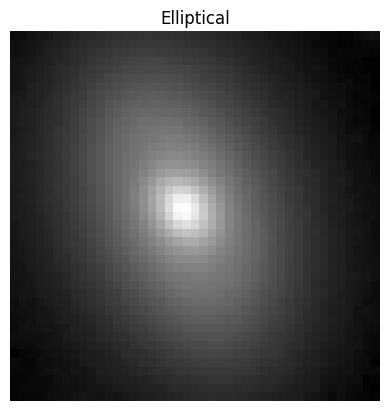

In [6]:
x=1
plt.axis('off')
plt.title(f"Elliptical")
plt.imshow(abs(cutouts[:,:,0,x])**0.25,cmap=cm.gray, interpolation='nearest')


Spiral galaxies can look rather different depending on the angle by which they are viewed.

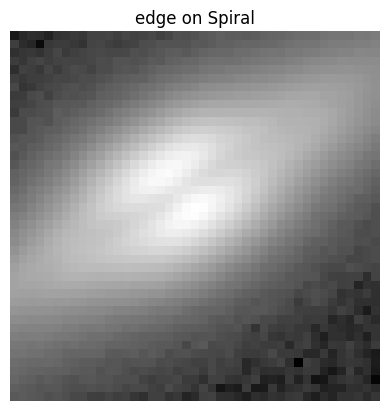

In [7]:
x=7870
plt.axis('off')
plt.title(f"edge on Spiral")
plt.imshow(abs(cutouts[:,:,0,x])**0.25,cmap=cm.gray, interpolation='nearest')

The dark strip in the center is not always visible in practice for edge on spiral galaxies. 

The name giving spiral structure is visible face on. 

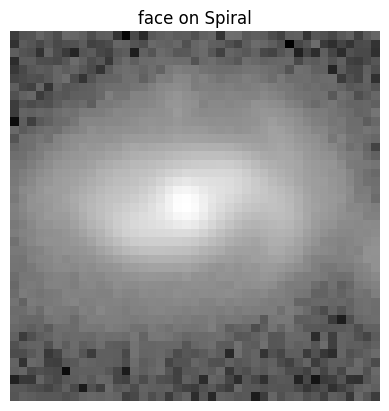

In [8]:
x=18
plt.axis('off')
plt.title(f"face on Spiral")
plt.imshow(abs(cutouts[:,:,0,x])**0.125,cmap=cm.gray, interpolation='nearest')

However, some spirals only display other deviations from the simple structures of ellipticals, like a ring in the following case. 

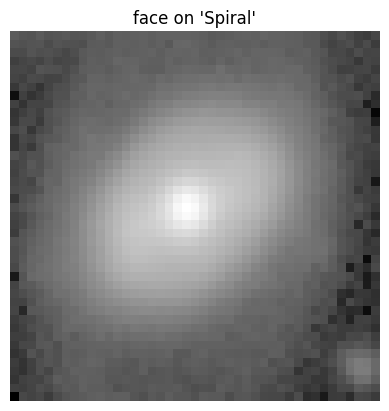

In [9]:
x=7874
plt.axis('off')
plt.title(f"face on 'Spiral'")
plt.imshow(abs(cutouts[:,:,0,x])**0.15,cmap=cm.gray, interpolation='nearest')

Thus, it is clear that there is a variation in structure between different examples of the same class. 

Next I add the image pixel information to the data frame, these data will be used by the algorithms which do not work on images but on tables.  I just run two loops within each other, thus the order is not particular meaningful.

In [10]:
x=0
for i in range(cutouts.shape[0]):
    for j in range(cutouts.shape[1]):
        df[x]=cutouts[i,j,0,:]
        x+=1
print(df)    
#there are warnings but it works 

      Unnamed: 0  index                objid          ra       dec  psfMag_u  \
0              0      1  1237663237128388701   50.130513 -1.228488  22.01211   
1              1    123  1237666299481817102   50.160628 -1.035026  19.01124   
2              2    140  1237663237128388949   50.167304 -1.241885  22.36878   
3              3    458  1237666300018557091   50.006004 -0.495751  21.98376   
4              4    110  1237663238739067202   50.387910  0.198944  21.86834   
...          ...    ...                  ...         ...       ...       ...   
7870         101    101  1237663543675126583  312.305638  0.325466  21.65428   
7871         102    243  1237663543675060734  312.252401  0.351028  21.40535   
7872         103    257  1237678596459004706  312.353091  0.906897  20.69301   
7873         104    263  1237678596459070093  312.482143  0.899587  20.42247   
7874         105      8  1237678617933840840  312.415661  0.836877  21.30678   

      psfMag_g  psfMag_r  psfMag_i  psf

Next I am splitting the data set into test and train. 

In [11]:
#images_test/train are feature for convolutional network 
feature_train, feature_test, target_train, target_test,image_train,image_test,df_train,df_test= train_test_split(df.iloc[:,51:1900],df.loc[:,"spiral"],cutouts.T,df,train_size=0.60, shuffle=True, random_state=1)
print("shape of image train data is")
print(image_train.shape)

shape of image train data is
(4725, 1, 43, 43)


## Fitting the original dataset

I use 4 different algorithms for classifications, two are not neural networks, these are logistic regression and XGBoost. Secondly, I use two neural networks, a multi-layer perceptron and a convolutional network. In all besides the convolutional network the structure of the image is not preserved in the input but flattened into a single vector. Then the algorithm finds pixels which are connected on its own, or as in case for logistic just consider all independently (I don’t understand this part of the sentence). Only in case of the convolutional network the image structure is considered by design.

Standard settings usually lead to overfitting, this is visible when the classifications are clearly better in the training than in the test.

The data set does not have so many examples. Thus, I optimize only one parameter. I choose l2 regularization, since it exists for all algorithms. I change the values in steps of 1, 3, 10, and so on to achieve about equal logarithmic step size.

It can happen that the neural networks convergence is not fast and occasionally not so good, so the results are saved. To select a good case, I combine several runs. I choose the train set to select the best results for a given regularization, that way I can still use test to choose the best regularization. I use log-loss for minimization as the fitting algorithm does.

In [12]:
#loading and expanding fit output
stats_mlp1=expand_2_output("mlp_4n_v2_full_gal_240.txt")
stats_mlp2=expand_2_output("mlp_4n_v2_full_gal_400.txt")
stats_mlp3=expand_2_output("mlp_4n_v2_full_gal_100.txt")
stats_mlp4=expand_2_output("mlp_4n_v2b_full_gal_300.txt")
stats_mlp5=expand_2_output("mlp_4n_v2b_full_gal_360.txt")
stats_mlp6=expand_2_output("mlp_4n_v2b_full_gal_440.txt")
stats_mlp7=expand_2_output("mlp_4n_v2b_full_gal_370.txt")
stats_mlp8=expand_2_output("mlp_4n_v2b_full_gal_460.txt")

stats_conv1=expand_2_output("conv2d_4n_v2_full_gal_240.txt")
stats_conv2=expand_2_output("conv2d_4n_v2b_full_gal_360.txt")
stats_conv3=expand_2_output("conv2d_4n_v2b_full_gal_340.txt")
stats_conv4=expand_2_output("conv2d_4n_v2b_full_gal_350.txt")
#combining choosing teh best train log loss
list_per=[stats_mlp1,stats_mlp2,stats_mlp3,stats_mlp4,stats_mlp5,stats_mlp6,stats_mlp7,stats_mlp8]
stats_mlp=combine_fit_results(list_per,minimise='log_loss_train')
list_conv=[stats_conv1,stats_conv2,stats_conv3,stats_conv4]
stats_conv=combine_fit_results(list_conv,minimise='log_loss_train')

I get now also the files from the other algorithms and then plot all, first the F1 score. 
 The F1 score considers all kinds of misclassifications, the best score is 1.0.

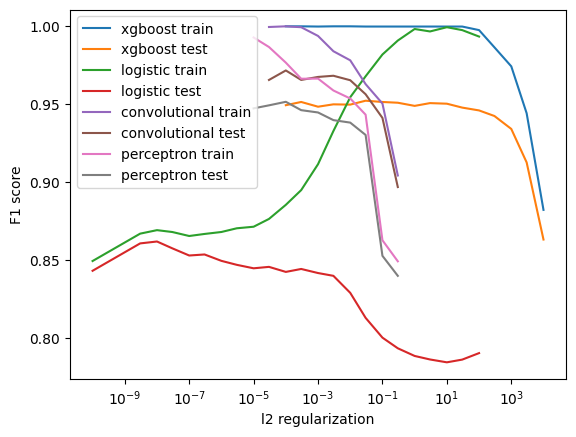

In [13]:
stats_xgb=np.loadtxt("xgb_43sets_gal-type_v1.txt")
stats_log=np.loadtxt("log_43sets_gal-type_v1.txt")

plt.plot(stats_xgb[0],stats_xgb[1],label='xgboost train')
plt.plot(stats_xgb[0],stats_xgb[2],label='xgboost test')
plt.plot(stats_log[0],stats_log[1],label='logistic train')
plt.plot(stats_log[0],stats_log[2],label='logistic test')
plt.plot(stats_conv[0],stats_conv[1],label='convolutional train')
plt.plot(stats_conv[0],stats_conv[2],label='convolutional test')
plt.plot(stats_mlp[0],stats_mlp[1],label='perceptron train')
plt.plot(stats_mlp[0],stats_mlp[2],label='perceptron test')
plt.legend(loc="best")

plt.xlabel('l2 regularization')
plt.ylabel('F1 score')
plt.xscale("log")

Logistic here is clearly worse than the rest, I now zoom in to the better values so that differences between the others are more obvious.

(0.92, 1.001)

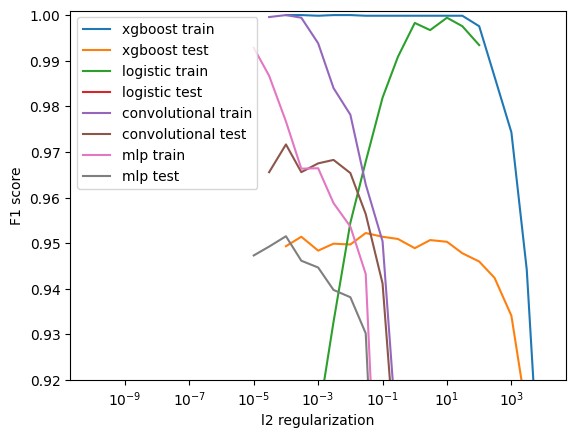

In [14]:
plt.plot(stats_xgb[0],stats_xgb[1],label='xgboost train')
plt.plot(stats_xgb[0],stats_xgb[2],label='xgboost test')
plt.plot(stats_log[0],stats_log[1],label='logistic train')
plt.plot(stats_log[0],stats_log[2],label='logistic test')
plt.plot(stats_conv[0],stats_conv[1],label='convolutional train')
plt.plot(stats_conv[0],stats_conv[2],label='convolutional test')
plt.plot(stats_mlp[0],stats_mlp[1],label='mlp train')
plt.plot(stats_mlp[0],stats_mlp[2],label='mlp test')
plt.legend(loc="best")
#plt.title('Loss vs Epochs')
plt.xlabel('l2 regularization')
plt.ylabel('F1 score')
plt.xscale("log")
plt.ylim(0.92,1.001)

The multi-layer perceptron has the smallest F1 in train, thus it is likely not fully converged or smaller regularizations are needed to explore. For logistic a too small number of iterations causes an imperfect F1 score for the right most points. However, both are not real problems since performance in the test is what matters.

Convolutional network has the highest F1 score for the test, xgboost and multi-layer perceptron have similarly good F1 scores. All peaks are rather broad and in case of the neural networks likely influenced by the number of iterations and randomness.

I am now looking on log loss. Here 0 is the best possible value and larger values are worse. I zoom in to the better values to ignore the worst part of logistic.

(0.0, 0.6)

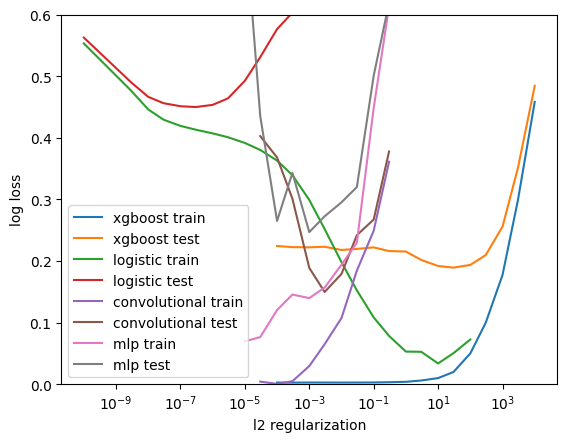

In [15]:
plt.plot(stats_xgb[0],stats_xgb[3],label='xgboost train')
plt.plot(stats_xgb[0],stats_xgb[4],label='xgboost test')
plt.plot(stats_log[0],stats_log[3],label='logistic train')
plt.plot(stats_log[0],stats_log[4],label='logistic test')
plt.plot(stats_conv[0],stats_conv[3],label='convolutional train')
plt.plot(stats_conv[0],stats_conv[4],label='convolutional test')
plt.plot(stats_mlp[0],stats_mlp[3],label='mlp train')
plt.plot(stats_mlp[0],stats_mlp[4],label='mlp test')
plt.legend(loc="best")
plt.xlabel('l2 regularization')
plt.ylabel('log loss')
plt.xscale("log")
plt.ylim(0,0.6)

Here the minima are more clear. Thus, I use them to choose the best models. The F1 score is still close to the best since the minima for it are broad. The best model is the convolutional network, then xgbboost and then the perceptron network and logistic regression are clearly the worst methods.

I now load the best models which I saved before. 

In [16]:
#logistic
log_single = pickle.load(open('best_log_single.sav', 'rb'))
#xgboost
xgb_single=XGBClassifier()
xgb_single.load_model("xgboost_model_spiral_ell_v1.json")
#convolutional network
PATH='conv2d_2layers_reg0.003_300epochs.pkl'
#parameter is keep prob but does only matter for fitting not applying for daata
conv_single =CNNBinary4(1)
conv_single.load_state_dict(torch.load(PATH))
conv_single.eval()
#multilayer perceptron network , parmeters is number of features 
PATH2='mlp_4layers_reg0.001_400epochs.pkl'
mlp_single =BinaryClassification4(1849)
mlp_single.load_state_dict(torch.load(PATH2))
mlp_single.eval()

BinaryClassification4(
  (fc1): Linear(in_features=1849, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=30, bias=True)
  (fc4): Linear(in_features=30, out_features=10, bias=True)
  (fc5): Linear(in_features=10, out_features=1, bias=True)
)

I then get the predictions for test and train for all models.

In [17]:
#first transforming into torch data structure
target_train, target_test = np.array(target_train), np.array(target_test)
feature_train, feature_test = np.array(feature_train), np.array(feature_test)
train_im_dataset = ClassificationDataset(torch.from_numpy(image_train).float(), torch.from_numpy(target_train).float())
test_im_dataset = ClassificationDataset(torch.from_numpy(image_test).float(), torch.from_numpy(target_test).float())
train_dataset = ClassificationDataset(torch.from_numpy(feature_train).float(), torch.from_numpy(target_train).float())
test_dataset = ClassificationDataset(torch.from_numpy(feature_test).float(), torch.from_numpy(target_test).float())
test_im_loader = DataLoader(dataset=test_im_dataset, batch_size=1)
train_im_loader_pred = DataLoader(dataset=train_im_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)
train_loader_pred = DataLoader(dataset=train_dataset, batch_size=1)
#then predictions for test and train for each 
m_test_pred=pred_torch(mlp_single,test_loader)
m_train_pred=pred_torch(mlp_single,train_loader_pred)
c_test_pred=pred_torch(conv_single,test_im_loader)
c_train_pred=pred_torch(conv_single,train_im_loader_pred)
x_train_pred=xgb_single.predict_proba(feature_train)
x_test_pred=xgb_single.predict_proba(feature_test)
l_train_pred=log_single.predict_proba(feature_train)
l_test_pred=log_single.predict_proba(feature_test)

Next I make confusion matrix and display them. First Logistic for the training set.. 

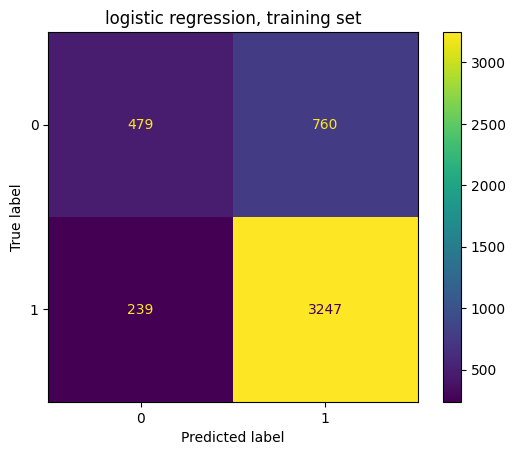

In [18]:
l_conf_train = confusion_matrix(target_train, np.round(l_train_pred[:,1]), labels=log_single.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=l_conf_train,
                               display_labels=log_single.classes_)
disp.plot()
plt.title(f"logistic regression, training set")
plt.show()

It is visible, that the rarer class (class=0, elliptical) is in the majority wrong classified. It is often the case the rare class is more difficult to classify, but that is clearly too bad to be accpetable, thus the look on the test set is not needed in this case. 

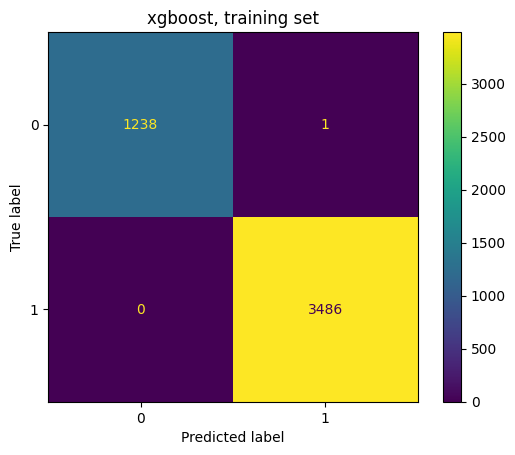

In [19]:
x_conf_train = confusion_matrix(target_train, np.round(x_train_pred[:,1]), labels=xgb_single.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=x_conf_train,
                               display_labels=xgb_single.classes_)
disp.plot()
plt.title(f"xgboost, training set")
plt.show()

Xgboost is much better, only one missclassification, but that is so good that it is nearly certainly overfitting. Thus, I look on the test set now. 

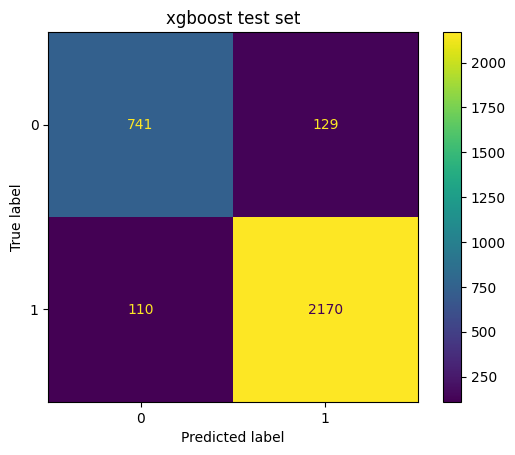

In [20]:
x_conf_test = confusion_matrix(target_test, np.round(x_test_pred[:,1]), labels=xgb_single.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=x_conf_test,
                               display_labels=xgb_single.classes_)
disp.plot()
plt.title(f"xgboost test set")
plt.show()

Clearly more are missiclassified in test, but there is still a good classification also in the rarer class, only about 1/6 are missclassified. 

Now to the neural networks, I show only test now, since train is affected by overfitting.

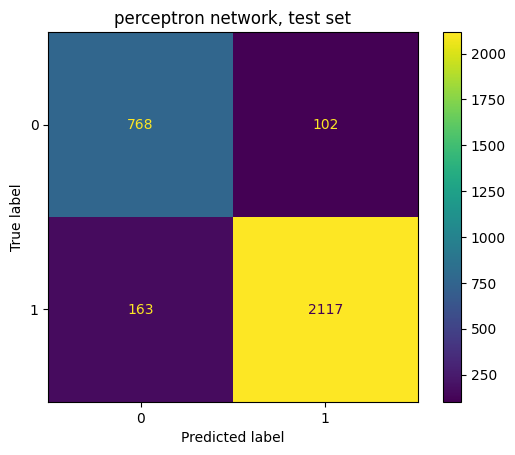

In [21]:
m_conf_test = confusion_matrix(target_test, np.round(m_test_pred[:]), labels=xgb_single.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=m_conf_test,
                               display_labels=xgb_single.classes_)
disp.plot()
plt.title(f"perceptron network, test set")
plt.show()

Similar good as xgboost overall but some differences, the predicted class 0 is purer, and the reverse is true for the more common class 1 (spirals).

Last the convolutional network. 

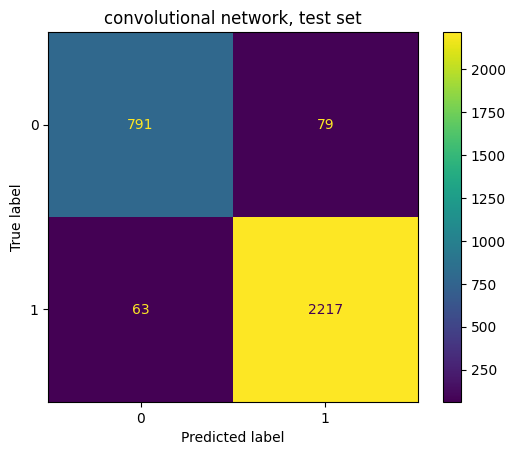

In [22]:
c_conf_test = confusion_matrix(target_test, np.round(c_test_pred[:]), labels=xgb_single.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=c_conf_test,
                               display_labels=xgb_single.classes_)
disp.plot()
plt.title(f"convolutional network, test set")
plt.show()

This is clearly best in all possible metrics. 

Next I look on some missclassified cases to identify problems in classification. The true classification is displayed at the top. It is red when it is not recognised, it is in green when it is found. 

I start with the worst case logistic. In the top as comment I indicate my per eye classification since it is unlikely that all input classifications are correct. 

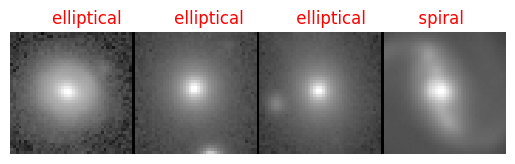

In [23]:
#elliptical/spiral, elliptical, elliptical, spiral 
plot_images(image_test,target_test,l_test_pred[:,1],[0,1,2,3],single=True,scale=0.25, different=True)

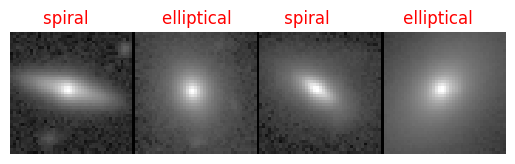

In [24]:
#spiral, elliptical, spiral, elliptical
plot_images(image_test,target_test,l_test_pred[:,1],[4,5,6,7],single=True,scale=0.25, different=True)

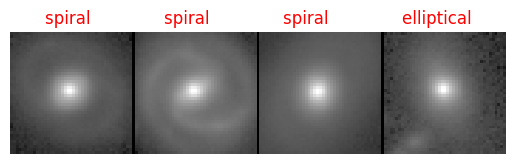

In [25]:
#spiral, spiral, spiral, elliptical
plot_images(image_test,target_test,l_test_pred[:,1],[8,9,10,11],single=True,scale=0.25, different=True)

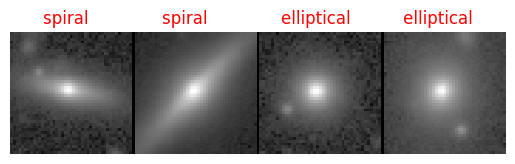

In [26]:
#spiral, spiral, elliptical, elliptical
plot_images(image_test,target_test,l_test_pred[:,1],[12,13,14,15],single=True,scale=0.25, different=True)

I agree with nearly all input classifications here. Many missclassifications are elliptical for them the main reason is likely that as the minor class there are more often missclassified.

Below I look on correct classifications. 

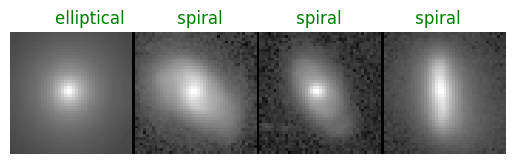

In [27]:
#elliptical, spiral, spiral, spiral 
plot_images(image_test,target_test,l_test_pred[:,1],[0,1,2,3],single=True,scale=0.25, different=False)

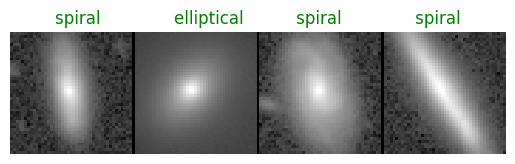

In [28]:
#spiral, elliptical, spiral, spiral 
plot_images(image_test,target_test,l_test_pred[:,1],[4,5,6,7],single=True,scale=0.25, different=False)

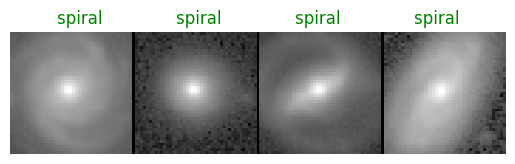

In [29]:
#spiral, elliptical, spiral, spiral 
plot_images(image_test,target_test,l_test_pred[:,1],[8,9,10,11],single=True,scale=0.25, different=False)

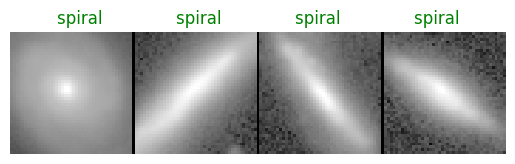

In [30]:
#spiral, spiral, spiral, spiral 
plot_images(image_test,target_test,l_test_pred[:,1],[12,13,14,15],single=True,scale=0.25, different=False)

In one case I do not agree per eye with the input class. In general it are spiral galaxies of many different types. There are only few elliptical galaxies, since most are missclassified. 

Now looking on convolutional network results, the best method. First some correct classified ones. 

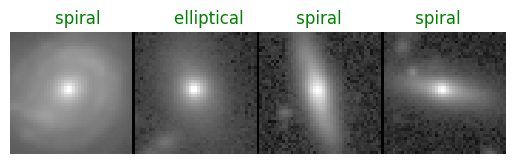

In [31]:
#spiral, elliptical, spiral, spiral
plot_images(image_test,target_test,c_test_pred,[50,51,52,53],scale=0.25,different=False,single=True)

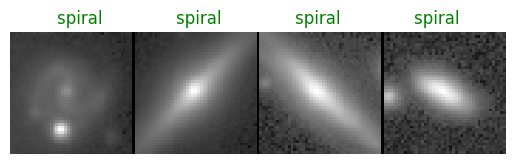

In [32]:
#spiral, spiral, spiral, spiral
plot_images(image_test,target_test,c_test_pred,[54,55,56,57],scale=0.25,different=False,single=True)

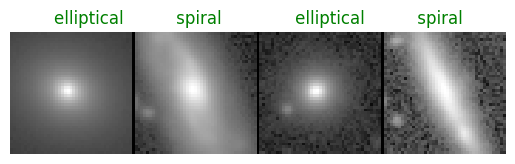

In [33]:
#elliptical, spiral, elliptical, spiral
plot_images(image_test,target_test,c_test_pred,[58,59,60,61],scale=0.25,different=False,single=True)

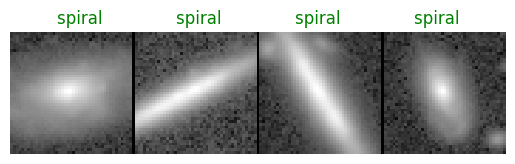

In [34]:
#spiral, spiral, spiral, spiral
plot_images(image_test,target_test,c_test_pred,[62,63,64,65],scale=0.25,different=False,single=True)

In all cases I agree with the input classfications. Most are spiral as expected because there are more of them, but there are also elliptical galaxies.

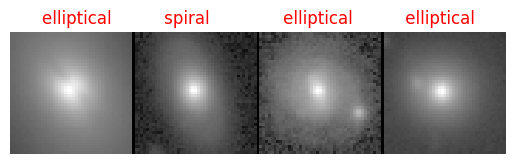

In [35]:
#elliptical (but dust lane add structure and makes to a borderline case, also definition wise), 
#elliptical?, spiral?, elliptical
plot_images(image_test,target_test,c_test_pred,[10,11,12,13],scale=0.25,different=True,single=True)

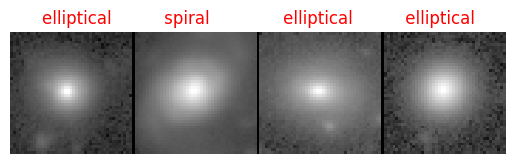

In [36]:
#elliptical,  spiral, elliptical, elliptical
plot_images(image_test,target_test,c_test_pred,[14,15,16,17],scale=0.25,different=True,single=True)

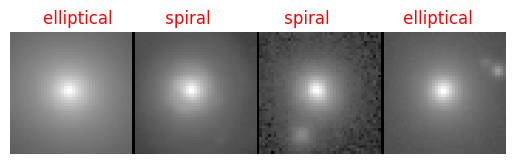

In [37]:
#elliptical, spiral?, elliptical, elliptical 
plot_images(image_test,target_test,c_test_pred,[18,19,20,21],scale=0.25,different=True,single=True)

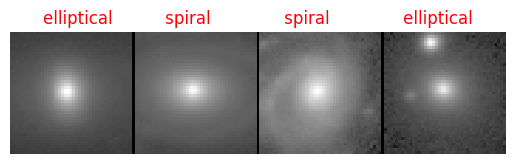

In [38]:
#elliptical, spiral?, spiral, elliptical 
plot_images(image_test,target_test,c_test_pred,[22,23,24,25],scale=0.25,different=True,single=True)

Many are difficult to classify per eye and some seem missclassfied. While it is possible that for some the features are outside the used image window, it seems unlikely to be the only reason. It is also possible that these are truly missclassified, since this classification was done by different citizen scientist and is thus not homogenous. The cictizen scientist also used less deep data, thus when here very weak feature are visible they were likely not visible in the original images. 
 

## Data augmentation and fits of this data set

With 7875 examples (of which 60% are in the training set), the data set is not much larger than the number of features per example which is 1849. It is not possible to add more examples to the data set since either the image or the classfication quality decreases with an expansion. Therefore I use data augmention as method to expand the training set. I considered using data with added noise, but this actually decreases the scores for my models.

I then considered the following option. On the sky the orientation of images and thus galaxies is meaningless. Thus, a simple methods to increase the training set by data augmentation is to add rotated and mirrored versions. That adds 7 more cases for our quadratic image and thus increase the data set by a factor 8. 
Below I call it rotation augmented for simplicity. 


This augmentation can be done in the training set and in the test. First I look how it matters when it is used in the training set. 

The fits take even more time as before, thus I just load the results here. 
Here I show the F1 score.  

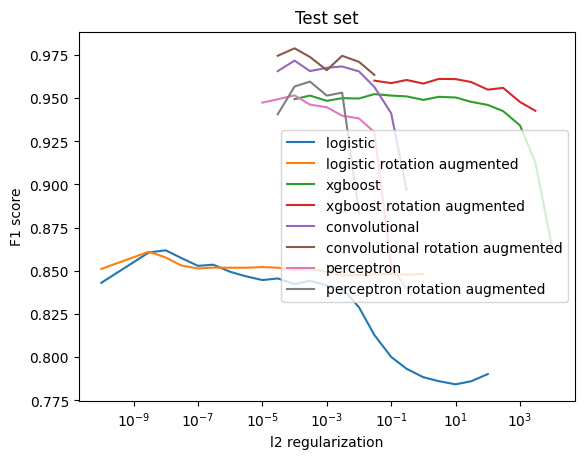

In [39]:
#single xgbgboost fit files
stats_xgb2=np.loadtxt("xgb_rotmir_mode0.txt")
#two logistic result files for rotation augmentation
stats_log2a=np.loadtxt("log_43sets_gal-type_mirr_rot_v1.txt")
stats_log2b=np.loadtxt("log_43sets_gal-type_mirr_rot_v2.txt")
#combine the two inputs
stats_log2=np.zeros((5,stats_log2a.shape[1]+stats_log2b.shape[1]))
stats_log2[:,0:15]=stats_log2a
stats_log2[:,15:19]=stats_log2b
#load fit files for neural network, and list of the models which made them
stats_mlp2a=np.loadtxt("mlp_fits_all_stats.txt")
stats_conv2a=np.loadtxt("conv_fits_all_stats.txt")
model_listc2=["conv2d_2layers_reg3e-05_rotmir_160epochs_v0.pkl","conv2d_2layers_reg3e-05_rotmir_240epochs.pkl","conv2d_2layers_reg0.0001_rotmir_160epochs_v0.pkl","conv2d_2layers_reg0.0001_rotmir_240epochs_v0.pkl",
             "conv2d_2layers_reg0.0003_rotmir_240epochs.pkl","conv2d_2layers_reg0.0003_rotmir_40epochs_v0.pkl",
              "conv2d_2layers_reg0.0003_rotmir_80epochs_v0.pkl","conv2d_2layers_reg0.0003_rotmir_80epochs_v1.pkl",
              "conv2d_2layers_reg0.0003_rotmir_80epochs_v2.pkl","conv2d_2layers_reg0.001_rotmir_240epochs.pkl"
             ,"conv2d_2layers_reg0.001_rotmir_80epochs_v0.pkl","conv2d_2layers_reg0.003_rotmir_240epochs.pkl",
             "conv2d_2layers_reg0.003_rotmir_80epochs_v0.pkl","conv2d_2layers_reg0.01_rotmir_240epochs.pkl","conv2d_2layers_reg0.01_rotmir_40epochs_v0.pkl",
             "conv2d_2layers_reg0.01_rotmir_80epochs_v0.pkl","conv2d_2layers_reg0.03_rotmir_80epochs_v0.pkl"]
model_listp2=["mlp_4layers_reg0.00003_rotmir_400epochs.pkl","mlp_4layers_reg0.0001_rotmir_400epochs_v0.pkl","mlp_4layers_reg0.0001_rotmir_400epochs_v1.pkl","mlp_4layers_reg0.0001_rotmir_400epochs_v2.pkl","mlp_4layers_reg0.001_rotmir_400epochs.pkl","mlp_4layers_reg0.0001_rotmir_440epochs.pkl","mlp_4layers_reg0.0003_rotmir_400epochs_v0.pkl","mlp_4layers_reg0.0003_rotmir_400epochs.pkl","mlp_4layers_reg0.001_rotmir_400epochs.pkl","mlp_4layers_reg0.001_rotmir_200epochs_v0.pkl","mlp_4layers_reg0.003_rotmir_400epochs.pkl","mlp_4layers_reg0.003_rotmir_200epochs_v0.pkl","mlp_4layers_reg0.01_rotmir_200epochs_v0.pkl"]
#choosen best one for each regularization in the combination below 
bestlossmlp,list_bestlossmlp=combine_fit_results2(stats_mlp2a,1,model_listp2,minimise='log_loss_train')
#convoltional also slecte with keep prob, keep prob=0.75 is the one which is better and is used in the following
bestlossconv1,list_bestlossconv1=combine_fit_results2(stats_conv2a,1,model_listc2,minimise='log_loss_train')
bestlossconv0,list_bestlossconv0=combine_fit_results2(stats_conv2a,0.75,model_listc2,minimise='log_loss_train')
plt.plot(stats_log[0],stats_log[2],label='logistic ')
plt.plot(stats_log2[0],stats_log2[2],label='logistic rotation augmented')
plt.plot(stats_xgb[0],stats_xgb[2],label='xgboost')
plt.plot(stats_xgb2[0],stats_xgb2[2],label='xgboost rotation augmented')
plt.plot(stats_conv[0],stats_conv[2],label='convolutional ')
plt.plot(bestlossconv0[0],bestlossconv0[5],label='convolutional rotation augmented')
plt.plot(stats_mlp[0],stats_mlp[2],label='perceptron')
plt.plot(bestlossmlp[0],bestlossmlp[5],label='perceptron rotation augmented')
plt.legend(loc="best")
plt.title('Test set')
plt.xlabel('l2 regularization')
plt.ylabel('F1 score')
plt.xscale("log")

The F1 score improves for most algorithms, the execption is logistic, which we mostly ignore form now on since it is clearly the worst algorithm. The improvements get better visible in the zoom below. 

(0.92, 0.98)

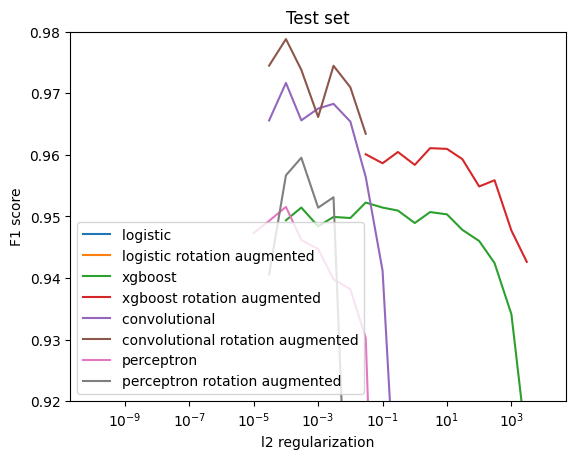

In [40]:
plt.plot(stats_log[0],stats_log[2],label='logistic ')
plt.plot(stats_log2[0],stats_log2[2],label='logistic rotation augmented')
plt.plot(stats_xgb[0],stats_xgb[2],label='xgboost')
plt.plot(stats_xgb2[0],stats_xgb2[2],label='xgboost rotation augmented')
plt.plot(stats_conv[0],stats_conv[2],label='convolutional ')
plt.plot(bestlossconv0[0],bestlossconv0[5],label='convolutional rotation augmented')
plt.plot(stats_mlp[0],stats_mlp[2],label='perceptron')
plt.plot(bestlossmlp[0],bestlossmlp[5],label='perceptron rotation augmented')
plt.legend(loc="best")
plt.title('Test set')
plt.xlabel('l2 regularization')
plt.ylabel('F1 score')
plt.xscale("log")
plt.ylim(0.92,0.98)

The improvement is clearest in xgboost because that is always converged, but also the networks improve at most regularizations. Next I look on log loss. 

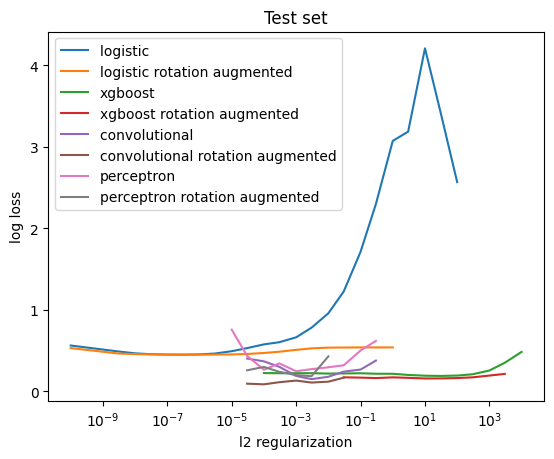

In [41]:
plt.plot(stats_log[0],stats_log[4],label='logistic ')
plt.plot(stats_log2[0],stats_log2[4],label='logistic rotation augmented')
plt.plot(stats_xgb[0],stats_xgb[4],label='xgboost')
plt.plot(stats_xgb2[0],stats_xgb2[4],label='xgboost rotation augmented')
plt.plot(stats_conv[0],stats_conv[4],label='convolutional ')
plt.plot(bestlossconv0[0],bestlossconv0[7],label='convolutional rotation augmented')
plt.plot(stats_mlp[0],stats_mlp[4],label='perceptron')
plt.plot(bestlossmlp[0],bestlossmlp[7],label='perceptron rotation augmented')
plt.legend(loc="best")
plt.title('Test set')
plt.xlabel('l2 regularization')
plt.ylabel('log loss')
plt.xscale("log")

Logistic does not improve at the optimum, just at the less good values. Again we zoom into the better values, ignoring logistic. 

(0.0, 0.4)

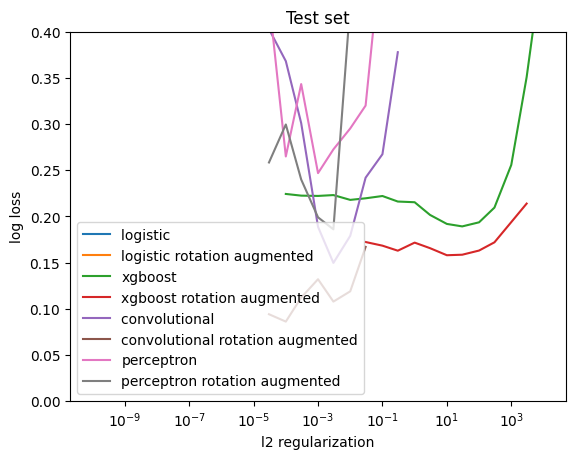

In [42]:
plt.plot(stats_log[0],stats_log[4],label='logistic ')
plt.plot(stats_log2[0],stats_log2[4],label='logistic rotation augmented')
plt.plot(stats_xgb[0],stats_xgb[4],label='xgboost')
plt.plot(stats_xgb2[0],stats_xgb2[4],label='xgboost rotation augmented')
plt.plot(stats_conv[0],stats_conv[4],label='convolutional ')
plt.plot(bestlossconv0[0],bestlossconv0[7],label='convolutional rotation augmented')
plt.plot(stats_mlp[0],stats_mlp[4],label='perceptron')
plt.plot(bestlossmlp[0],bestlossmlp[7],label='perceptron rotation augmented')
plt.legend(loc="best")
plt.title('Test set')
plt.xlabel('l2 regularization')
plt.ylabel('log loss')
plt.xscale("log")
plt.ylim(0,0.4)

There is similar improves for most regularization values, still convolutional is best then xgboost is slightly better than the perceptron.
The convolutional network, does not anymore has a clear minimum because in the used fits the parameter keep prob was set to 0.75, which has the effect of mostly eliminating overfitting for all regularizations. 

Now I also consider rotations augmentations for the test set. I consider two option for combining the 8 cases, first taking the average of all 8 options and then taking the median of all 8 options. Since there exist only two classes, 100% probability is presevered automatically also for the median. 

First for the perceptron model.

(0.88, 0.965)

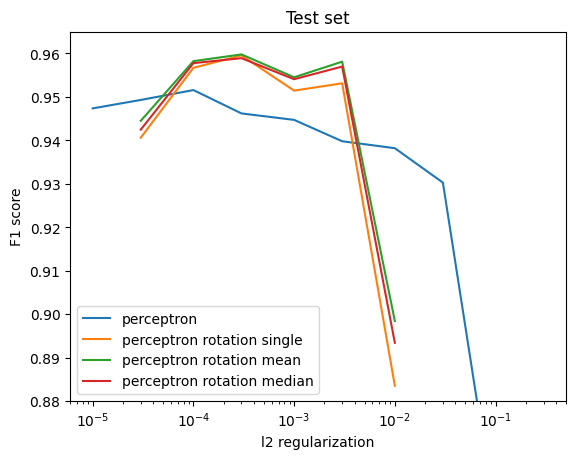

In [43]:
bestlossmlpa=np.loadtxt("mlp_rotmir_mode1b.txt")
bestlossmlpm=np.loadtxt("mlp_rotmir_mode2b.txt")
plt.plot(stats_mlp[0],stats_mlp[2],label='perceptron')
plt.plot(bestlossmlp[0],bestlossmlp[5],label='perceptron rotation single')
plt.plot(bestlossmlpa[0],bestlossmlpa[2],label='perceptron rotation mean')
plt.plot(bestlossmlpm[0],bestlossmlpm[2],label='perceptron rotation median')
plt.legend(loc="best")
plt.title('Test set')
plt.xlabel('l2 regularization')
plt.ylabel('F1 score')
plt.xscale("log")
plt.ylim(0.88,0.965)

There is an improvement by using augmenation also on test data but the improvement is smaller than when using it only in the training data. Mean combination is slightly better than median combination. Now the log loss score. 

(0.15, 0.45)

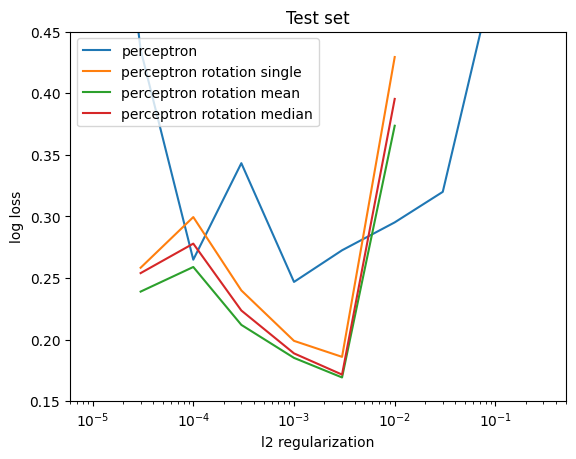

In [44]:
plt.plot(stats_mlp[0],stats_mlp[4],label='perceptron')
plt.plot(bestlossmlp[0],bestlossmlp[7],label='perceptron rotation single')
plt.plot(bestlossmlpa[0],bestlossmlpa[4],label='perceptron rotation mean')
plt.plot(bestlossmlpm[0],bestlossmlpm[4],label='perceptron rotation median')
plt.legend(loc="best")
plt.title('Test set')
plt.xlabel('l2 regularization')
plt.ylabel('log loss')
plt.xscale("log")
plt.ylim(0.15,0.45)

That looks very similar, but with more equal improvement for all regularization. That is likely because since the log loss is not quantized it depends less on chance.

Next the convolutional networks. 

(0.95, 0.985)

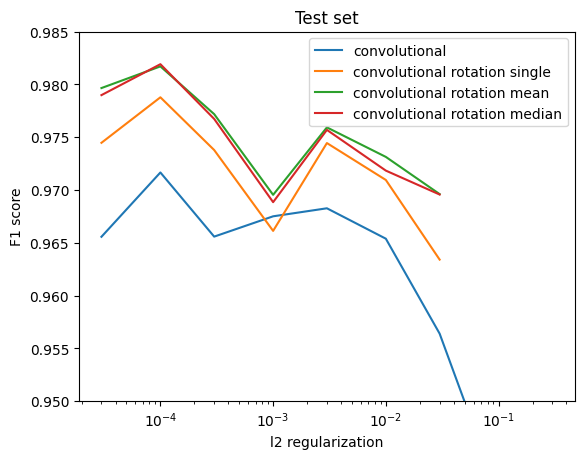

In [45]:
bestlossconv0a=np.loadtxt("conv_rotmir_mode1b_k0.txt")
bestlossconv0m=np.loadtxt("conv_rotmir_mode2b_k0.txt")
plt.plot(stats_conv[0],stats_conv[2],label='convolutional')
plt.plot(bestlossconv0[0],bestlossconv0[5],label='convolutional rotation single')
plt.plot(bestlossconv0a[0],bestlossconv0a[2],label='convolutional rotation mean')
plt.plot(bestlossconv0m[0],bestlossconv0m[2],label='convolutional rotation median')
plt.legend(loc="best")
plt.title('Test set')
plt.xlabel('l2 regularization')
plt.ylabel('F1 score')
plt.xscale("log")
plt.ylim(0.95,0.985)

Again similar, a improvement with augmentation in test and usually a larger one with using the mean. 

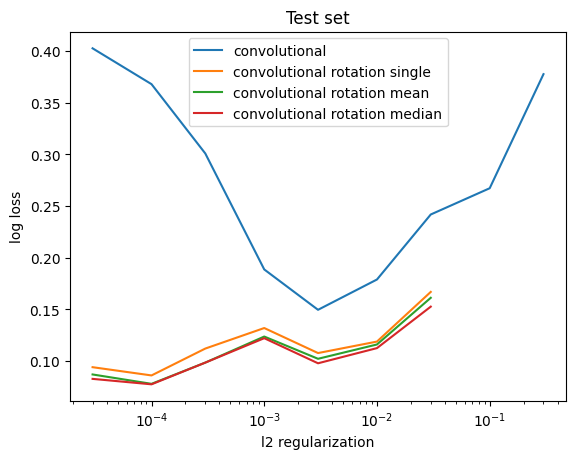

In [46]:
plt.plot(stats_conv[0],stats_conv[4],label='convolutional')
plt.plot(bestlossconv0[0],bestlossconv0[7],label='convolutional rotation single')
plt.plot(bestlossconv0a[0],bestlossconv0a[4],label='convolutional rotation mean')
plt.plot(bestlossconv0m[0],bestlossconv0m[4],label='convolutional rotation median')
plt.legend(loc="best")
plt.title('Test set')
plt.xlabel('l2 regularization')
plt.ylabel('log loss')
plt.xscale("log")

Again it looks similar, last the xgboost option. 

(0.93, 0.97)

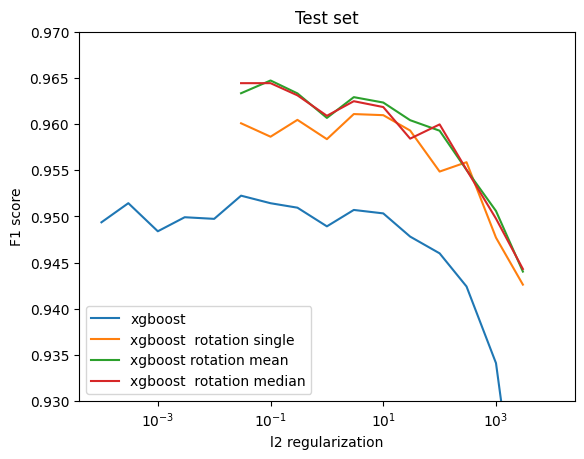

In [47]:
stats_xgb2a=np.loadtxt("xgb_rotmir_mode1.txt")
stats_xgb2m=np.loadtxt("xgb_rotmir_mode2.txt")
plt.plot(stats_xgb[0],stats_xgb[2],label='xgboost')
plt.plot(stats_xgb2[0],stats_xgb2[2],label='xgboost  rotation single')
plt.plot(stats_xgb2a[0],stats_xgb2a[2],label='xgboost rotation mean')
plt.plot(stats_xgb2m[0],stats_xgb2m[2],label='xgboost  rotation median')
plt.legend(loc="best")
plt.title('Test set')
plt.xlabel('l2 regularization')
plt.ylabel('F1 score')
plt.xscale("log")
plt.ylim(0.93,0.97)

Again there is usually a improvement using rotation augmentation and mean is better than median most of the time. 

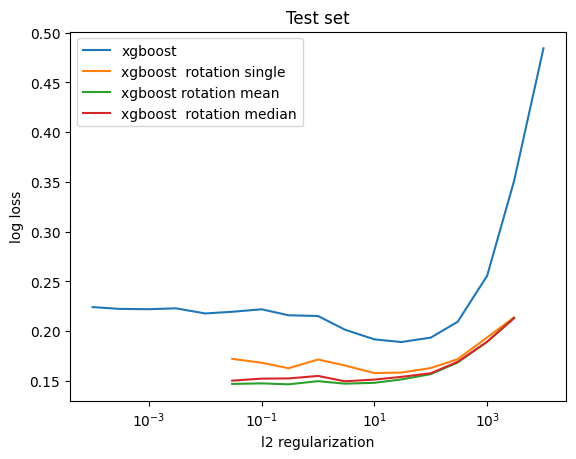

In [48]:
plt.plot(stats_xgb[0],stats_xgb[4],label='xgboost')
plt.plot(stats_xgb2[0],stats_xgb2[4],label='xgboost  rotation single')
plt.plot(stats_xgb2a[0],stats_xgb2a[4],label='xgboost rotation mean')
plt.plot(stats_xgb2m[0],stats_xgb2m[4],label='xgboost  rotation median')
plt.legend(loc="best")
plt.title('Test set')
plt.xlabel('l2 regularization')
plt.ylabel('log loss')
plt.xscale("log")
#plt.ylim(0.93,0.97)

As for the perceptron the improvement is more constant in log loss. 

Thus, I use mean combination also for the test data.
I plot it for the three algorithms and select the best model with log loss. 

best xgboost model is xgboost_model_spiral_ell_rot_mirr_l2reg3.json
best convolutional model is conv2d_2layers_reg0.0001_rotmir_240epochs_v0.pkl
best perceptron model is mlp_4layers_reg0.003_rotmir_200epochs_v0.pkl


(0.07, 0.27)

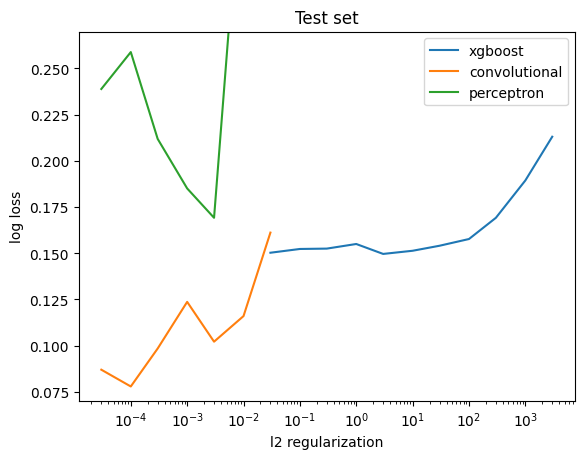

In [49]:
xmodel_list=["xgboost_model_spiral_ell_rot_mirr_l2reg0.03.json","xgboost_model_spiral_ell_rot_mirr_l2reg0.1.json","xgboost_model_spiral_ell_rot_mirr_l2reg0.3.json","xgboost_model_spiral_ell_rot_mirr_l2reg1.json","xgboost_model_spiral_ell_rot_mirr_l2reg3.json","xgboost_model_spiral_ell_rot_mirr_l2reg10.json","xgboost_model_spiral_ell_rot_mirr_l2reg30.json","xgboost_model_spiral_ell_rot_mirr_l2reg100.json","xgboost_model_spiral_ell_rot_mirr_l2reg300.json","xgboost_model_spiral_ell_rot_mirr_l2reg1000.json","xgboost_model_spiral_ell_rot_mirr_l2reg3000.json"]
best_xmodel=xmodel_list[np.argmin(stats_xgb2m[4])]
best_cmodel=list_bestlossconv0[np.argmin(bestlossconv0a[4])]
best_mmodel=list_bestlossmlp[np.argmin(bestlossmlpa[4])]
print(f"best xgboost model is {best_xmodel}")
print(f"best convolutional model is {best_cmodel}")
print(f"best perceptron model is {best_mmodel}")
plt.plot(stats_xgb2m[0],stats_xgb2m[4],label='xgboost')
plt.plot(bestlossconv0a[0],bestlossconv0a[4],label='convolutional')
plt.plot(bestlossmlpa[0],bestlossmlpa[4],label='perceptron')
plt.legend(loc="best")
plt.title('Test set')
plt.xlabel('l2 regularization')
plt.ylabel('log loss')
plt.xscale("log")
plt.ylim(0.07,0.27)

The best model is convolutional, then xgboost then percpetron. Howver all are good enough enough that it is possible that a combination possible gains, thus we look on them together partly below. 

Next the F1 score of them, with the best model from above marked with a dot. 

(0.95, 0.985)

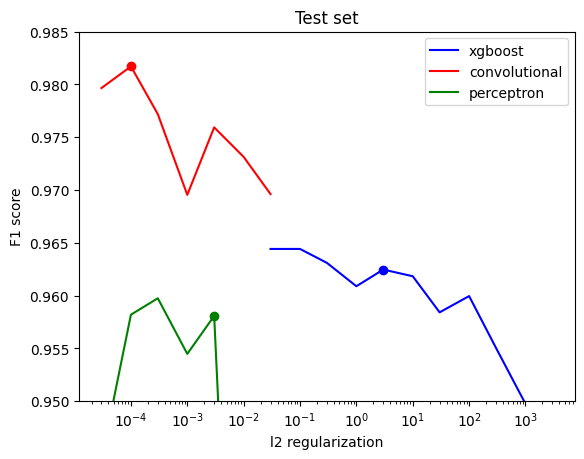

In [50]:
plt.plot(stats_xgb2m[0],stats_xgb2m[2],label='xgboost',color='blue')
plt.plot(bestlossconv0a[0],bestlossconv0a[2],label='convolutional',color='red')
plt.plot(bestlossmlpa[0],bestlossmlpa[2],label='perceptron',color='green')
plt.plot(stats_xgb2m[0,np.argmin(stats_xgb2m[4])],stats_xgb2m[2,np.argmin(stats_xgb2m[4])],'o',color='blue')
plt.plot(bestlossconv0a[0,np.argmin(bestlossconv0a[4])],bestlossconv0a[2,np.argmin(bestlossconv0a[4])],'o',color='red')
plt.plot(bestlossmlpa[0,np.argmin(bestlossmlpa[4])],bestlossmlpa[2,np.argmin(bestlossmlpa[4])],'o',color='green')
plt.legend(loc="best")
plt.title('Test set')
plt.xlabel('l2 regularization')
plt.ylabel('F1 score')
plt.xscale("log")
plt.ylim(0.95,0.985)

In the F1 score convolutional is clearly best as expected since it is designed for images. 

Now I get the different best predictions for test and train. They are done eleswhere, because with rotation augmentation it takes now longer. 

In [51]:
c_pred_train=np.loadtxt("best_v0_conv_rottrain_prob.txt")
c_pred_test=np.loadtxt("best_v0_conv_rottest_prob.txt")
x_pred_train=np.loadtxt("best_v0_xgb_rottrain_prob.txt")
x_pred_test=np.loadtxt("best_v0_xgb_rottest_prob.txt")
m_pred_train=np.loadtxt("best_v0_per_rottrain_prob.txt")
m_pred_test=np.loadtxt("best_v0_per_rottest_prob.txt")
#Here I add them to the data frames 
df_train['xgb_sp_prob']=x_pred_train
df_train['conv_sp_prob']=c_pred_train
df_train['per_sp_prob']=m_pred_train
df_train['median_sp_prob']=df_train[['per_sp_prob','conv_sp_prob','xgb_sp_prob']].median(axis=1)
df_train['mean_sp_prob']=df_train[['per_sp_prob','conv_sp_prob','xgb_sp_prob']].mean(axis=1)
df_test['xgb_sp_prob']=x_pred_test
df_test['conv_sp_prob']=c_pred_test
df_test['per_sp_prob']=m_pred_test
df_test['median_sp_prob']=df_test[['per_sp_prob','conv_sp_prob','xgb_sp_prob']].median(axis=1)
df_test['mean_sp_prob']=df_test[['per_sp_prob','conv_sp_prob','xgb_sp_prob']].mean(axis=1)

Now, I get the confusion matrix for the test cases for the possible best models. 

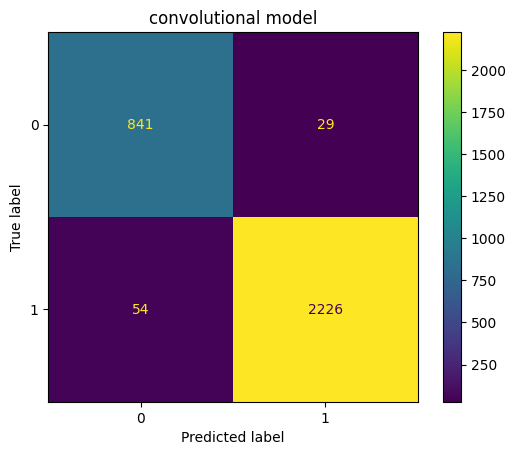

In [52]:
c2_conf_train = confusion_matrix(target_test, np.round(df_test['conv_sp_prob']), labels=log_single.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=c2_conf_train,
                               display_labels=log_single.classes_)
disp.plot()
plt.title(f"convolutional model")
plt.show()

This is clearly better than before the data augmenatation, when 79 with a predicted label for class 1 had a true label 0 and 63 with a predicted label 0 had a true label 1. Especially the rarer class is now better, likely because a smaller regularization is now possible with keep probability of 0.75. 

Next I look on mean and median of thnree models, to see whether they are better. 

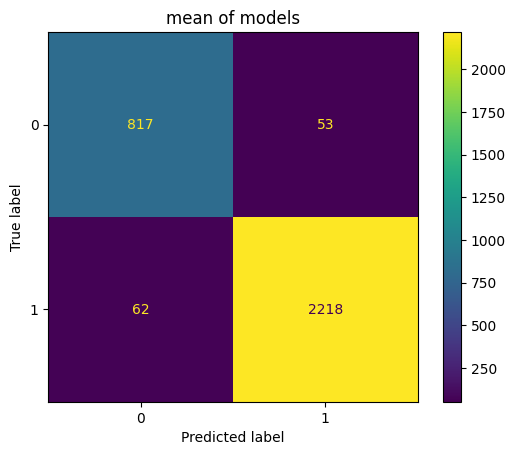

In [53]:
c3_conf_train = confusion_matrix(target_test, np.round(df_test['mean_sp_prob']), labels=log_single.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=c3_conf_train,
                               display_labels=log_single.classes_)
disp.plot()
plt.title(f"mean of models")
plt.show()

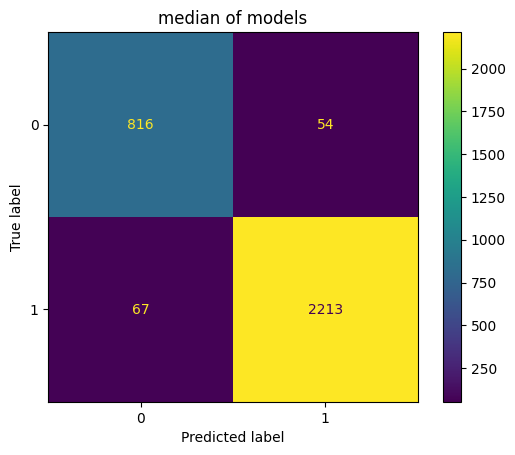

In [54]:
c3_conf_train = confusion_matrix(target_test, np.round(df_test['median_sp_prob']), labels=log_single.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=c3_conf_train,
                               display_labels=log_single.classes_)
disp.plot()
plt.title(f"median of models")
plt.show()

The median and mean of all models is worse in both missclassifications. Thus the convolutional model is likely the best option when one cannot choose a save option of considering several options. 

As another test I look per eye on the 16 worst missclassifications of convolutional in test, that means the cases with the smallest probability for the right class.  

probablity difference of 16th worst classifictation 0.98999


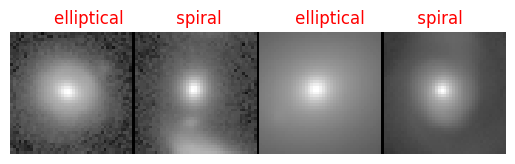

In [55]:
#spiral?, elliptical (disturbed by a likely spiral galaxy in cutout), elliptical, spiral?
print(f"probablity difference of 16th worst classifictation {np.round(-np.sort(-abs(target_test-c_test_pred))[15],5)}")
plot_images(image_test,target_test,c_test_pred,[0,1,2,3],single=True,scale=0.25, different=True,lim=0.98999)

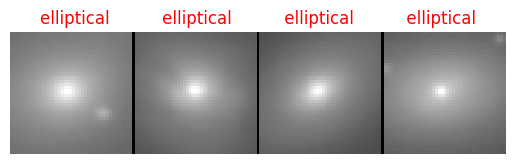

In [56]:
#elliptical, elliptical (distrurbed by dust), elliptical, elliptical
plot_images(image_test,target_test,c_test_pred,[4,5,6,7],single=True,scale=0.25, different=True,lim=0.98999)

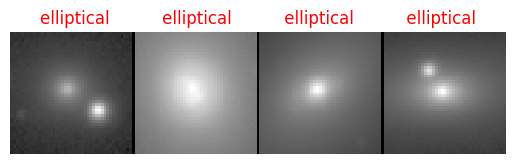

In [57]:
#elliptical, elliptical, elliptical, elliptical
plot_images(image_test,target_test,c_test_pred,[8,9,10,11],single=True,scale=0.25, different=True,lim=0.98999)

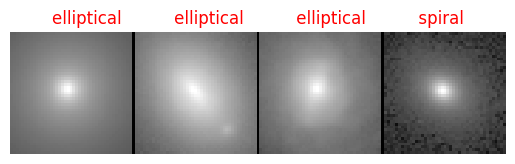

In [58]:
#elliptical, elliptical?, spiral?, ellipticial 
plot_images(image_test,target_test,c_test_pred,[12,13,14,15],single=True,scale=0.25, different=True,lim=0.98999)

While some (4 to 5) seem missclassified, others are not. The algorithm seems to have problems sometimes when there is a second source in the field of view. I repeat the same with the median of the three models. 

probablity difference of 16th worst classifictation 0.942


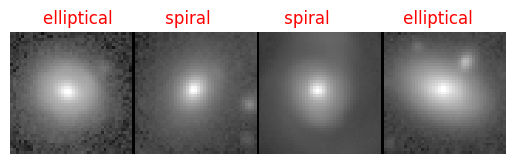

In [59]:
print(f"probablity difference of 16th worst classifictation {np.round(-np.sort(-abs(target_test-df_test.median_sp_prob))[15],3)}")
#spiral?, elliptical, spiral, elliptical?
plot_images(image_test,target_test,np.array(df_test.median_sp_prob),[0,1,2,3],single=True,scale=0.25, different=True,lim=0.942)

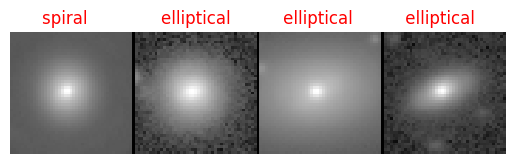

In [60]:
#elliptical, elliptical, elliptical, spiral
plot_images(image_test,target_test,np.array(df_test.median_sp_prob),[4,5,6,7],single=True,scale=0.25, different=True,lim=0.942)

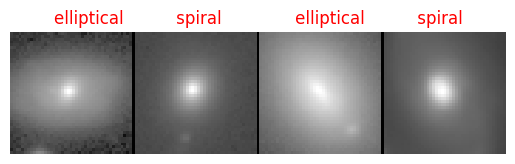

In [61]:
#spiral?, elliptical, elliptical?,  elliptical?
plot_images(image_test,target_test,np.array(df_test.median_sp_prob),[8,9,10,11],single=True,scale=0.25, different=True,lim=0.942)

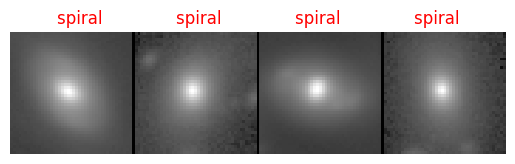

In [62]:
# spiral, elliptical, spiral, elliptical
plot_images(image_test,target_test,np.array(df_test.median_sp_prob),[12,13,14,15],single=True,scale=0.25, different=True,lim=0.942)

Here more missclassified 9 about twice much, but with a sample of 16 it can also be chance still. In general it is also often difficult to decide for me which type something is.  Combining several seems to works at least for the extreme cases, it also reduces the certainty in this wrong classifications as expected when several numbers are combined. 

Now I looking on the best classified ones with more than 99% certainty. 

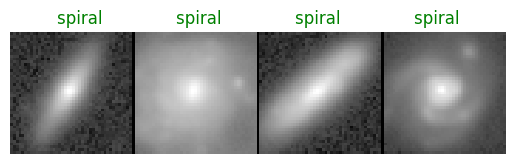

In [63]:
#spiral, spiral, spiral, elliptical
plot_images(image_test,target_test,np.array(df_test.conv_sp_prob),[82,83,84,85],single=True,scale=0.25, different=False,lim=0.99)

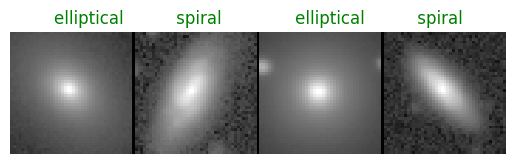

In [64]:
#elliptical, spiral, elliptical, spiral
plot_images(image_test,target_test,np.array(df_test.conv_sp_prob),[86,87,88,89],single=True,scale=0.25, different=False,lim=0.99)

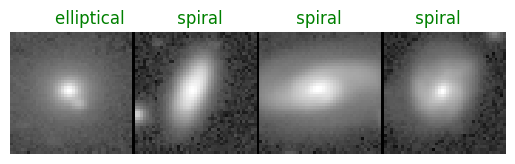

In [65]:
#elliptical, spiral, spiral, spiral
plot_images(image_test,target_test,np.array(df_test.conv_sp_prob),[90,91,92,93],single=True,scale=0.25, different=False,lim=0.99)

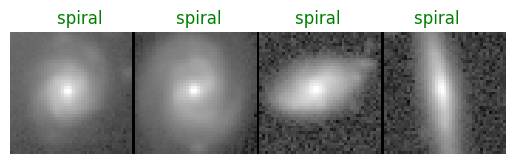

In [66]:
#spiral spiral, spiral, spiral
plot_images(image_test,target_test,np.array(df_test.conv_sp_prob),[94,95,96,97],single=True,scale=0.25, different=False,lim=0.99)

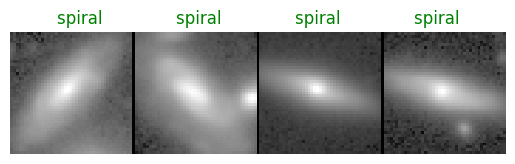

In [67]:
#spiral spiral, spiral, spiral
plot_images(image_test,target_test,np.array(df_test.conv_sp_prob),[98,99,100,101],single=True,scale=0.25, different=False,lim=0.99)

This selects mostly spiral galaxies, which are truly clear ones likely because the rarer class usually is less certain. The effect is even stronger when the median probablity is used instead a reason to use convolutional. 

## Application of the best models on other data sets

After looking on the test data set I now apply the models on other data, which can have more uncertain classifications or other less ideal properties.    

I start with a data set of galaxies which contains also the more zoo dataset classifications. I apply on it the three best models. 

In [68]:
#image and classes
images_allspec=['stripe82_27_allspec_im.npy']
classes_allspec=['stripe82_27_allspec_table.csv']
#getting for all  3 models
allspec_cpred,allspec_df,allspec_images=predict_probs(images_allspec,classes_allspec,'conv2d_2layers_reg0.0001_rotmir_240epochs_v0.pkl',modelname='convolutional',keep_prob=1)
allspec_xpred=predict_probs(images_allspec,classes_allspec,'xgboost_model_spiral_ell_rot_mirr_l2reg3.json',modelname='xgboost',image_output=False,df_output=False)
allspec_ppred=predict_probs(images_allspec,classes_allspec,'mlp_4layers_reg0.003_rotmir_200epochs_v0.pkl',modelname='perceptron',num_features=1849,image_output=False,df_output=False)

(415, 1, 43, 43)
number of tables is 1
shape of combined data frame (415, 51)
shape of image file is (415, 1, 43, 43)
(415, 1900)
Index(['Unnamed: 0',      'index',      'objid',         'ra',        'dec',
         'psfMag_u',   'psfMag_g',   'psfMag_r',   'psfMag_i',   'psfMag_z',
       ...
               1839,         1840,         1841,         1842,         1843,
               1844,         1845,         1846,         1847,         1848],
      dtype='object', length=1900)
Index(['Unnamed: 0', 'index', 'objid', 'ra', 'dec', 'psfMag_u', 'psfMag_g',
       'psfMag_r', 'psfMag_i', 'psfMag_z', 'probPSF_u', 'probPSF_g',
       'probPSF_r', 'probPSF_i', 'probPSF_z', 'modelMag_u', 'modelMag_g',
       'modelMag_r', 'modelMag_i', 'modelMag_z', 'petroRad_g', 'petroRad_r',
       'petroRad_i', 'run', 'rerun', 'camcol', 'field', 'type', 'specobjid',
       'class', 'subclass', 'redshift', 'plate', 'mjd', 'fiberid', 'nvote',
       'p_el', 'p_cw', 'p_acw', 'p_edge', 'p_dk', 'p_mg', 'p_el_de

8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
28

Now I plot the results against the input spiral probabily. This probably is not used for training because it is less reliable than using the 'certain' spiral and elliptical galaxies. 
First for convolutional network. 

Text(0, 0.5, 'convolutional spiral probability')

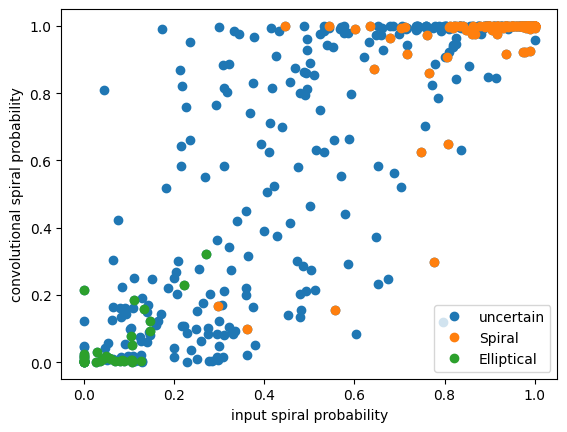

In [69]:
allspec_df['xgb_sp_prob']=allspec_xpred
allspec_df['conv_sp_prob']=allspec_cpred
allspec_df['per_sp_prob']=allspec_ppred
allspec_df['mean_sp_prob']=(allspec_ppred+allspec_cpred+allspec_xpred)/3
allspec_df['median_sp_prob']=allspec_df[['per_sp_prob','conv_sp_prob','xgb_sp_prob']].median(axis=1)
allspec_df_spi=allspec_df[(allspec_df.spiral==1)]
allspec_df_el=allspec_df[(allspec_df.elliptical==1)]
allspec_df_class=allspec_df[(allspec_df.elliptical==1) | (allspec_df.spiral==1)]
plt.plot(allspec_df.p_cs_debiased/(allspec_df.p_cs_debiased+allspec_df.p_el_debiased),allspec_df['conv_sp_prob'],'o',label='uncertain')
plt.plot(allspec_df_spi.p_cs_debiased/(allspec_df_spi.p_cs_debiased+allspec_df_spi.p_el_debiased),allspec_df_spi['conv_sp_prob'],'o',label='Spiral')
plt.plot(allspec_df_el.p_cs_debiased/(allspec_df_el.p_cs_debiased+allspec_df_el.p_el_debiased),allspec_df_el['conv_sp_prob'],'o',label='Elliptical')
plt.legend(loc="best")
plt.xlabel('input spiral probability')
plt.ylabel('convolutional spiral probability')

It looks about as expected. It is visible that the machine learning classification are more certain than the input probablities, they are more often close to 0 and 1. Classified ones (spiral and elliptical) in the input should have probabilities of less than 20% or more than 80% according to the publication. That is not fully the case, there were likely some changes in the table data after deciving the classified one. Next I look on the median. 

Text(0, 0.5, 'median spiral probability')

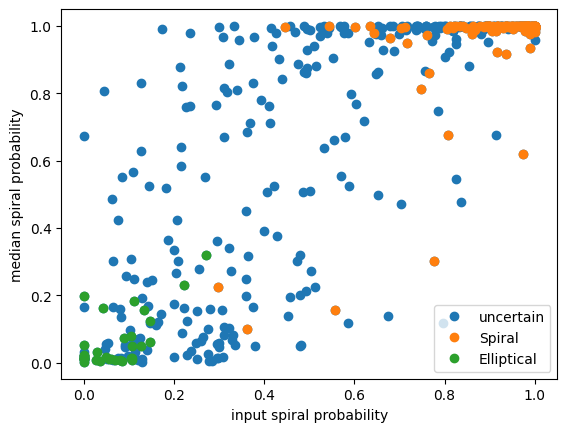

In [70]:
plt.plot(allspec_df.p_cs_debiased/(allspec_df.p_cs_debiased+allspec_df.p_el_debiased),allspec_df['median_sp_prob'],'o',label='uncertain')
plt.plot(allspec_df_spi.p_cs_debiased/(allspec_df_spi.p_cs_debiased+allspec_df_spi.p_el_debiased),allspec_df_spi['median_sp_prob'],'o',label='Spiral')
plt.plot(allspec_df_el.p_cs_debiased/(allspec_df_el.p_cs_debiased+allspec_df_el.p_el_debiased),allspec_df_el['median_sp_prob'],'o',label='Elliptical')
plt.legend(loc="best")
#plt.title('Test set')
plt.xlabel('input spiral probability')
plt.ylabel('median spiral probability')

In the median as for convoltional it is visible that the classes seem more reliable than the probablities, only in few cases the class change, while more often a not so high probability of a certain one gets large here. 

However, there are some peculiar cases,  which have a different classification than a rounded class. I now look on those. 

In [71]:
allspec_badclass=allspec_df_class[(np.round(allspec_df_class.p_cs_debiased/(allspec_df_class.p_cs_debiased+allspec_df_class.p_el_debiased))!=np.round(allspec_df_class.spiral))]
print("object with disagreeing classifications")
print(allspec_badclass.iloc[:,42:45])

object with disagreeing classifications
     p_el_debiased  p_cs_debiased  spiral
80           0.638          0.362       1
91           0.702          0.298       1
301          0.554          0.446       1


All are spiral galaxies according to class but not to probablity. Now I display all of them. Aboce the image the spiral probablity according to convolutional, xgboost and perceptron are displayed. 

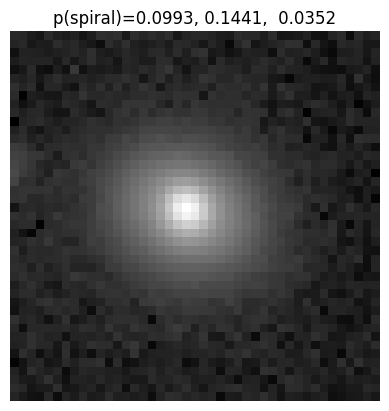

In [72]:
#is elliptical
x=80
plt.axis('off')
plt.title(f"p(spiral)={np.round(allspec_df.conv_sp_prob[x],4)}, {np.round(allspec_df.xgb_sp_prob[x],4)},  {np.round(allspec_df.per_sp_prob[x],4)}")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

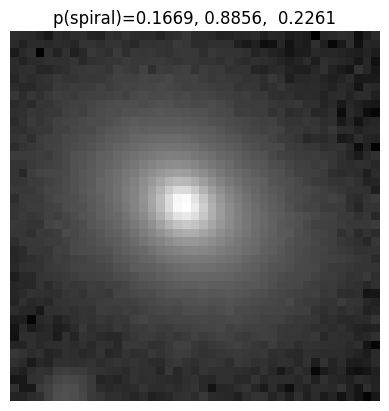

In [73]:
#is elliptical
x=91
plt.axis('off')
plt.title(f"p(spiral)={np.round(allspec_df.conv_sp_prob[x],4)}, {np.round(allspec_df.xgb_sp_prob[x],4)},  {np.round(allspec_df.per_sp_prob[x],4)}")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

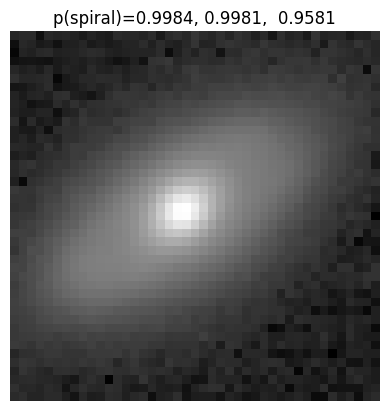

In [74]:
#is spiral
x=301
plt.axis('off')
plt.title(f"p(spiral)={np.round(allspec_df.conv_sp_prob[x],4)}, {np.round(allspec_df.xgb_sp_prob[x],4)},  {np.round(allspec_df.per_sp_prob[x],4)}")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

The last one which the highest p_cs_spiral looks like a spiral and is classfied as spiral probablities 
according to all machine leaning methods.
In contrast the other are elliptical as also found by most algorithms the exeption being ones xgboost. 

It looks like the algorithms are better than the provided classes for intermediate cases. However, the sample is small. Therefore I now look on number of cases with intermediate probablities and uncertain classes. 

In [75]:
print("objects with particulary uncertain input classifications")
allspec_dfint=allspec_df[(allspec_df.p_el_debiased>0.4) & (allspec_df.p_cs_debiased>0.4) & allspec_df.uncertain==1]
print(allspec_dfint.iloc[:,42:44])

objects with particulary uncertain input classifications
     p_el_debiased  p_cs_debiased
14           0.453          0.442
16           0.444          0.400
46           0.457          0.543
48           0.428          0.531
54           0.483          0.445
102          0.424          0.576
126          0.416          0.442
146          0.460          0.446
165          0.437          0.427
188          0.400          0.545
205          0.463          0.489
208          0.455          0.421
241          0.528          0.404
253          0.408          0.410
268          0.450          0.458
278          0.425          0.497
281          0.471          0.432
290          0.548          0.452
302          0.475          0.480
327          0.490          0.412
361          0.442          0.419
382          0.426          0.558
410          0.468          0.455


NowI look on all of them. 

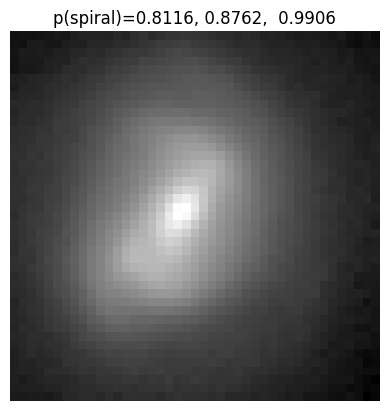

In [76]:
#spiral
x=14
plt.axis('off')
plt.title(f"p(spiral)={np.round(allspec_df.conv_sp_prob[x],4)}, {np.round(allspec_df.xgb_sp_prob[x],4)},  {np.round(allspec_df.per_sp_prob[x],4)}")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

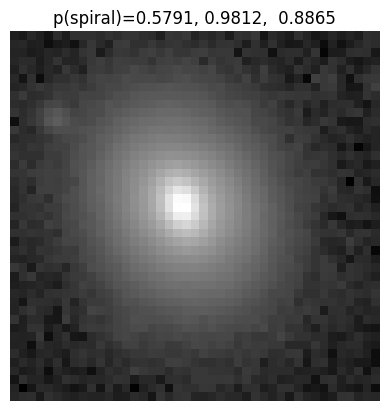

In [77]:
#elliptical
x=16
plt.axis('off')
plt.title(f"p(spiral)={np.round(allspec_df.conv_sp_prob[x],4)}, {np.round(allspec_df.xgb_sp_prob[x],4)},  {np.round(allspec_df.per_sp_prob[x],4)}")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

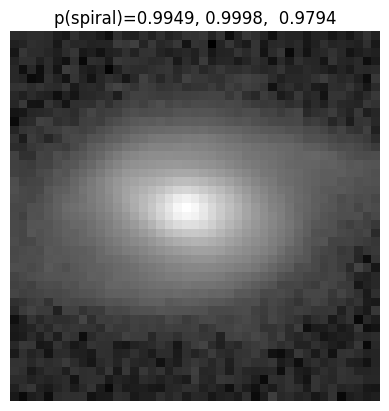

In [78]:
#spiral
x=46
plt.axis('off')
plt.title(f"p(spiral)={np.round(allspec_df.conv_sp_prob[x],4)}, {np.round(allspec_df.xgb_sp_prob[x],4)},  {np.round(allspec_df.per_sp_prob[x],4)}")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

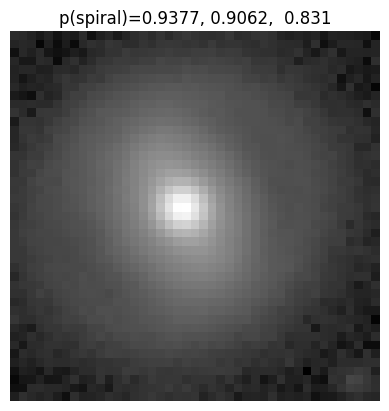

In [79]:
#Elliptical
x=48
plt.axis('off')
plt.title(f"p(spiral)={np.round(allspec_df.conv_sp_prob[x],4)}, {np.round(allspec_df.xgb_sp_prob[x],4)},  {np.round(allspec_df.per_sp_prob[x],4)}")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

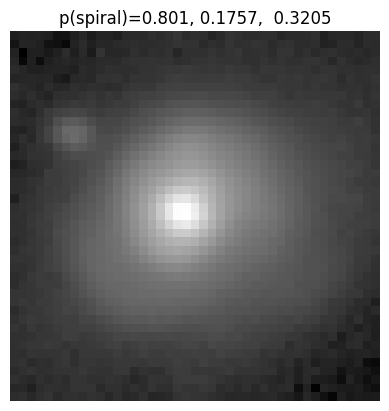

In [80]:
#kind of spiral, maybe merger
x=54
plt.axis('off')
plt.title(f"p(spiral)={np.round(allspec_df.conv_sp_prob[x],4)}, {np.round(allspec_df.xgb_sp_prob[x],4)},  {np.round(allspec_df.per_sp_prob[x],4)}")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

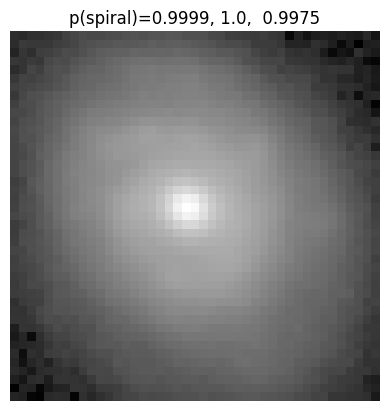

In [81]:
#spiral
x=102
plt.axis('off')
plt.title(f"p(spiral)={np.round(allspec_df.conv_sp_prob[x],4)}, {np.round(allspec_df.xgb_sp_prob[x],4)},  {np.round(allspec_df.per_sp_prob[x],4)}")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

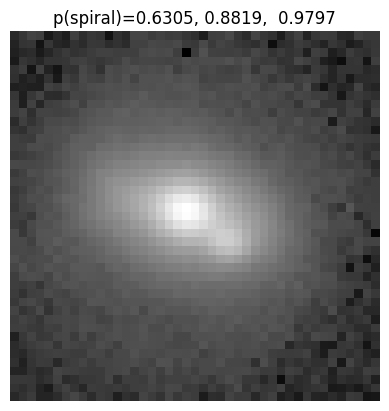

In [82]:
#spiral, maybe merger
x=126
plt.axis('off')
plt.title(f"p(spiral)={np.round(allspec_df.conv_sp_prob[x],4)}, {np.round(allspec_df.xgb_sp_prob[x],4)},  {np.round(allspec_df.per_sp_prob[x],4)}")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

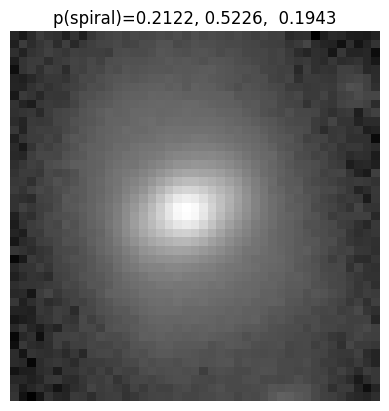

In [83]:
# uncertain
x=146
plt.axis('off')
plt.title(f"p(spiral)={np.round(allspec_df.conv_sp_prob[x],4)}, {np.round(allspec_df.xgb_sp_prob[x],4)},  {np.round(allspec_df.per_sp_prob[x],4)}")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

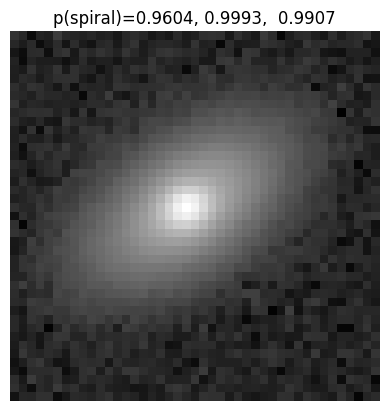

In [84]:
#spiral
x=165
plt.axis('off')
plt.title(f"p(spiral)={np.round(allspec_df.conv_sp_prob[x],4)}, {np.round(allspec_df.xgb_sp_prob[x],4)},  {np.round(allspec_df.per_sp_prob[x],4)}")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

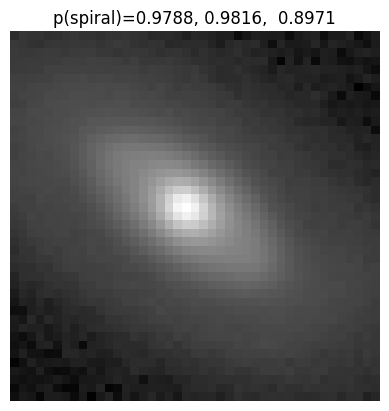

In [85]:
#spiral
x=188
plt.axis('off')
plt.title(f"p(spiral)={np.round(allspec_df.conv_sp_prob[x],4)}, {np.round(allspec_df.xgb_sp_prob[x],4)},  {np.round(allspec_df.per_sp_prob[x],4)}")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

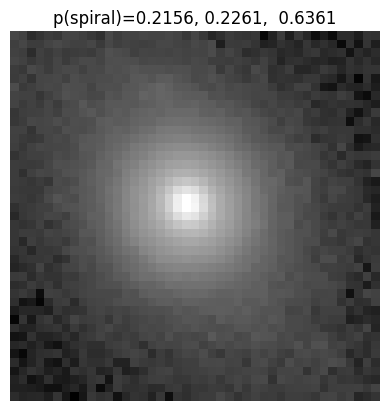

In [86]:
#elliptical
x=205
plt.axis('off')
plt.title(f"p(spiral)={np.round(allspec_df.conv_sp_prob[x],4)}, {np.round(allspec_df.xgb_sp_prob[x],4)},  {np.round(allspec_df.per_sp_prob[x],4)}")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

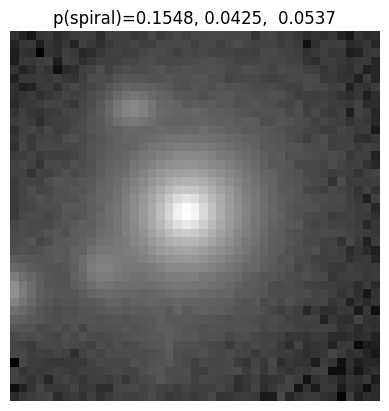

In [87]:
#elliptical? some sources closeby but does not change that 
x=208
plt.axis('off')
plt.title(f"p(spiral)={np.round(allspec_df.conv_sp_prob[x],4)}, {np.round(allspec_df.xgb_sp_prob[x],4)},  {np.round(allspec_df.per_sp_prob[x],4)}")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

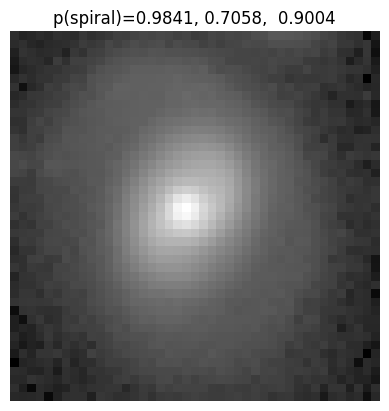

In [88]:
#spiral
x=241
plt.axis('off')
plt.title(f"p(spiral)={np.round(allspec_df.conv_sp_prob[x],4)}, {np.round(allspec_df.xgb_sp_prob[x],4)},  {np.round(allspec_df.per_sp_prob[x],4)}")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

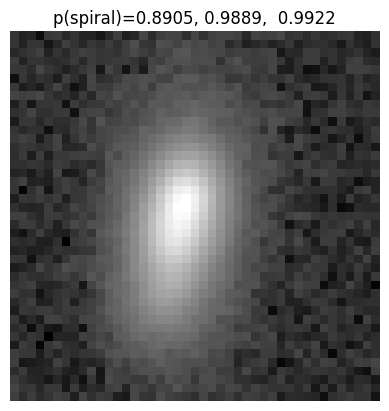

In [89]:
#spiral, some assymetry maybe merger hint? 
x=253
plt.axis('off')
plt.title(f"p(spiral)={np.round(allspec_df.conv_sp_prob[x],4)}, {np.round(allspec_df.xgb_sp_prob[x],4)},  {np.round(allspec_df.per_sp_prob[x],4)}")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

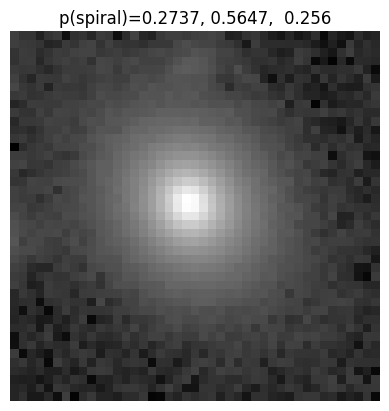

In [90]:
#elliptical
x=268
plt.axis('off')
plt.title(f"p(spiral)={np.round(allspec_df.conv_sp_prob[x],4)}, {np.round(allspec_df.xgb_sp_prob[x],4)},  {np.round(allspec_df.per_sp_prob[x],4)}")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

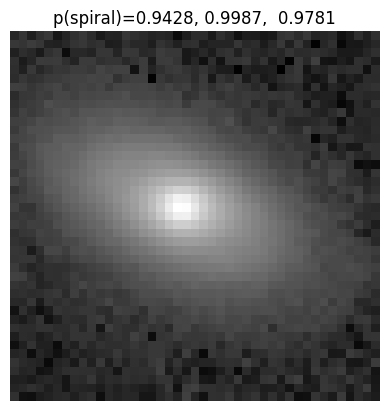

In [91]:
#spiral
x=278
plt.axis('off')
plt.title(f"p(spiral)={np.round(allspec_df.conv_sp_prob[x],4)}, {np.round(allspec_df.xgb_sp_prob[x],4)},  {np.round(allspec_df.per_sp_prob[x],4)}")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

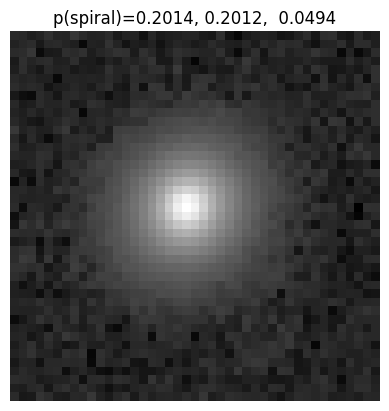

In [92]:
#elliptical
x=281
plt.axis('off')
plt.title(f"p(spiral)={np.round(allspec_df.conv_sp_prob[x],4)}, {np.round(allspec_df.xgb_sp_prob[x],4)},  {np.round(allspec_df.per_sp_prob[x],4)}")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

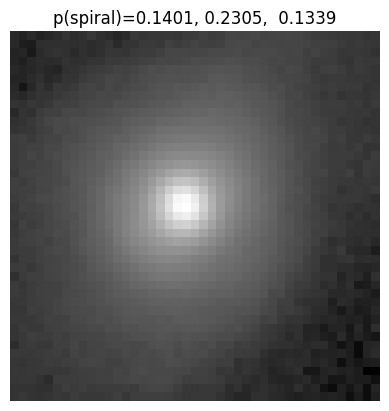

In [93]:
#elliptical
x=290
plt.axis('off')
plt.title(f"p(spiral)={np.round(allspec_df.conv_sp_prob[x],4)}, {np.round(allspec_df.xgb_sp_prob[x],4)},  {np.round(allspec_df.per_sp_prob[x],4)}")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

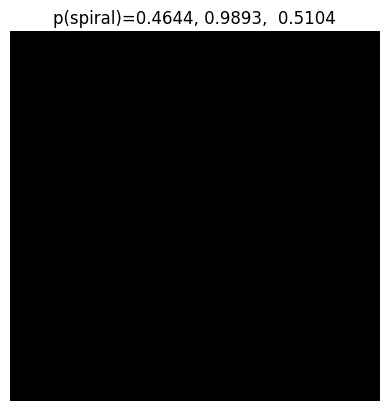

In [94]:
#nothing is in the data, should not have been used 
x=302
plt.axis('off')
plt.title(f"p(spiral)={np.round(allspec_df.conv_sp_prob[x],4)}, {np.round(allspec_df.xgb_sp_prob[x],4)},  {np.round(allspec_df.per_sp_prob[x],4)}")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')
#networks get resonable probablities close to 0.5, while xgboost gets rather certain, less good

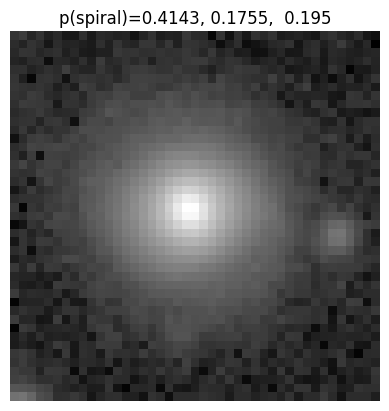

In [95]:
#elliptical
x=327
plt.axis('off')
plt.title(f"p(spiral)={np.round(allspec_df.conv_sp_prob[x],4)}, {np.round(allspec_df.xgb_sp_prob[x],4)},  {np.round(allspec_df.per_sp_prob[x],4)}")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

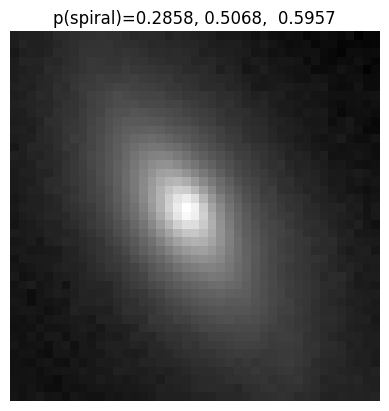

In [96]:
#spiral
x=361
plt.axis('off')
plt.title(f"p(spiral)={np.round(allspec_df.conv_sp_prob[x],4)}, {np.round(allspec_df.xgb_sp_prob[x],4)},  {np.round(allspec_df.per_sp_prob[x],4)}")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

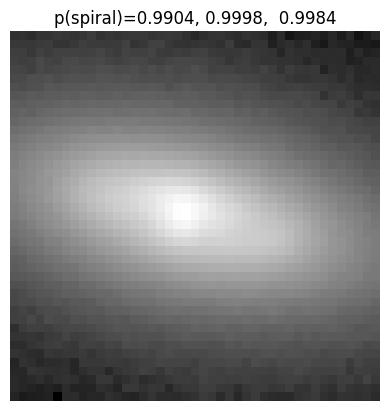

In [97]:
#spiral
x=382
plt.axis('off')
plt.title(f"p(spiral)={np.round(allspec_df.conv_sp_prob[x],4)}, {np.round(allspec_df.xgb_sp_prob[x],4)},  {np.round(allspec_df.per_sp_prob[x],4)}")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

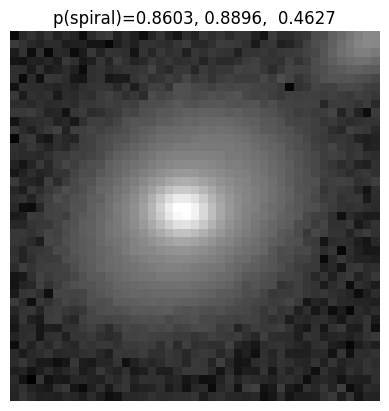

In [98]:
#spiral?
x=410
plt.axis('off')
plt.title(f"p(spiral)={np.round(allspec_df.conv_sp_prob[x],4)}, {np.round(allspec_df.xgb_sp_prob[x],4)},  {np.round(allspec_df.per_sp_prob[x],4)}")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

The majority are spiral galaxies here.

Of all galaxies, on 15 all methods ageed with my own classification, on one they disagreed, and on 7 different algorithm disagreed in the results. 
Looking on single classfications and excluding the two case I don't know the class, best are convolutional and median which agree in 20 of the cases, then follow xgboost and average with 19 and last perceptron with 18. However, the differences are so small that the differences are very likely chance. 

Overall we find that all algorithms perfrom better on the uncertain ones than the input. It does not necessary means that the method is better, since the images used by the algorithm are deeper.  

### Behaviour on unusual types of galaxies

Now I am looking on the objects which are neither certain elliptical and spiral galaxy and where also the combined probablity of two is low. These objects potentially belong to the other classes of objects. In the input other classes are don't know (dk, less interesting can be star or artefact) or merger (mg) of galaxies, which are more interesting. (Both a rare and less reliables, thus I do not use them in the supervised learning)
Merger show substructure,
in contrast to spiral it is not symmetric. For galaxies in large distances the substructure of mergers can be small and round and thus not certainly distingished from stars.  

In [99]:
print("potential neither spirals nor ellipticals")
allspec_dfnei=allspec_df[((allspec_df.p_el_debiased+allspec_df.p_cs_debiased)<0.5)]
print(allspec_dfnei.iloc[:,35:44])

potential neither spirals nor ellipticals
     nvote   p_el   p_cw  p_acw  p_edge   p_dk   p_mg  p_el_debiased  \
4       32  0.250  0.000  0.000   0.156  0.094  0.500          0.224   
41      24  0.292  0.000  0.000   0.042  0.125  0.542          0.292   
144     27  0.185  0.037  0.000   0.000  0.000  0.778          0.158   
224     22  0.500  0.045  0.045   0.045  0.136  0.227          0.248   
309     58  0.310  0.000  0.000   0.034  0.172  0.483          0.270   
328     30  0.133  0.067  0.033   0.167  0.100  0.500          0.059   
367     27  0.037  0.074  0.000   0.185  0.593  0.111          0.017   
407     25  0.320  0.000  0.120   0.080  0.480  0.000          0.184   

     p_cs_debiased  
4            0.175  
41           0.042  
144          0.044  
224          0.244  
309          0.046  
328          0.300  
367          0.267  
407          0.267  


Now I am plotting them all. As before is above the image displayed the main class(es) in the input and above as comment my input classfication. 

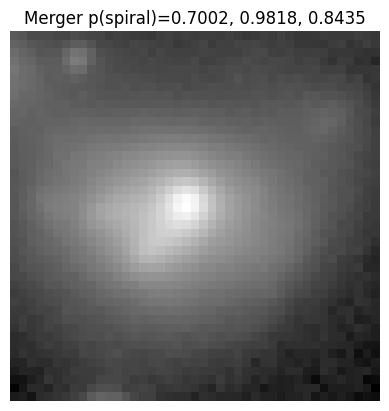

In [100]:
#likely merger
x=4
plt.axis('off')
plt.title(f"Merger p(spiral)={np.round(allspec_dfnei.conv_sp_prob[x],4)}, {np.round(allspec_dfnei.xgb_sp_prob[x],4)}, {np.round(allspec_dfnei.per_sp_prob[x],4)}")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

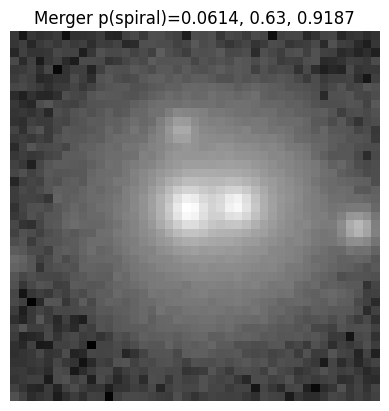

In [101]:
#probably merger
x=41
plt.axis('off')
plt.title(f"Merger p(spiral)={np.round(allspec_dfnei.conv_sp_prob[x],4)}, {np.round(allspec_dfnei.xgb_sp_prob[x],4)}, {np.round(allspec_dfnei.per_sp_prob[x],4)}")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

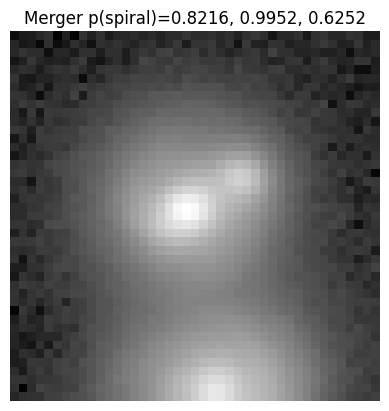

In [102]:
# merger
x=144
plt.axis('off')
plt.title(f"Merger p(spiral)={np.round(allspec_dfnei.conv_sp_prob[x],4)}, {np.round(allspec_dfnei.xgb_sp_prob[x],4)}, {np.round(allspec_dfnei.per_sp_prob[x],4)}")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

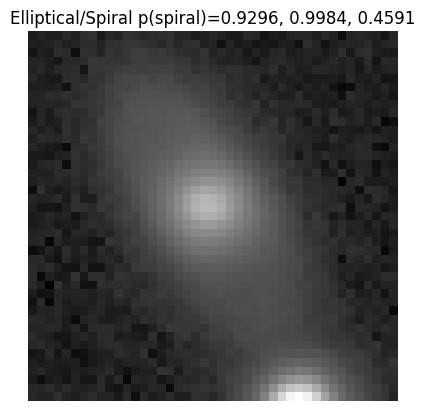

In [103]:
#probably spiral 
x=224
plt.axis('off')
plt.title(f"Elliptical/Spiral p(spiral)={np.round(allspec_dfnei.conv_sp_prob[x],4)}, {np.round(allspec_dfnei.xgb_sp_prob[x],4)}, {np.round(allspec_dfnei.per_sp_prob[x],4)}")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

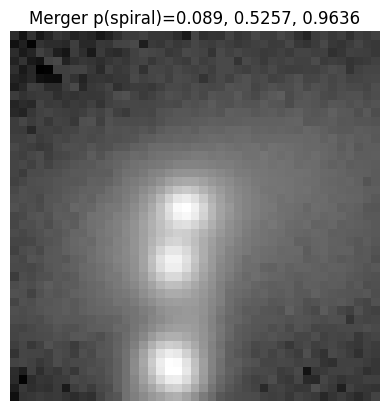

In [104]:
#likely merger
x=309
plt.axis('off')
plt.title(f"Merger p(spiral)={np.round(allspec_dfnei.conv_sp_prob[x],4)}, {np.round(allspec_dfnei.xgb_sp_prob[x],4)}, {np.round(allspec_dfnei.per_sp_prob[x],4)}")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

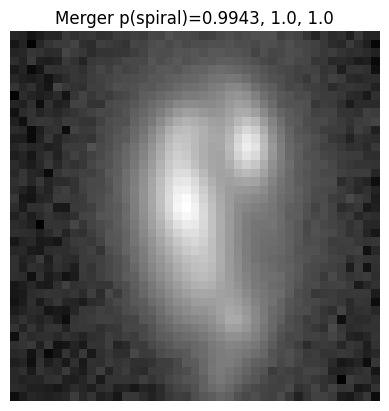

In [105]:
# merger
x=328
plt.axis('off')
plt.title(f"Merger p(spiral)={np.round(allspec_dfnei.conv_sp_prob[x],4)}, {np.round(allspec_dfnei.xgb_sp_prob[x],4)}, {np.round(allspec_dfnei.per_sp_prob[x],4)}")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

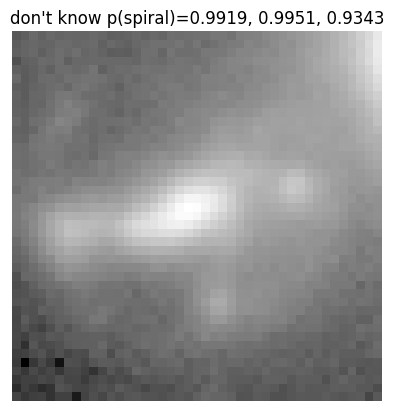

In [106]:
#merger
x=367
plt.axis('off')
plt.title(f"don't know p(spiral)={np.round(allspec_dfnei.conv_sp_prob[x],4)}, {np.round(allspec_dfnei.xgb_sp_prob[x],4)}, {np.round(allspec_dfnei.per_sp_prob[x],4)}")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

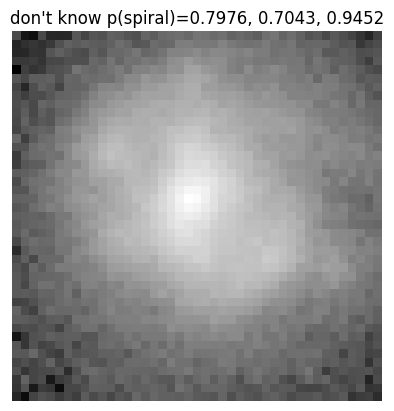

In [107]:
#probably spiral, difficult because faint
x=407
plt.axis('off')
plt.title(f"don't know p(spiral)={np.round(allspec_dfnei.conv_sp_prob[x],4)}, {np.round(allspec_dfnei.xgb_sp_prob[x],4)}, {np.round(allspec_dfnei.per_sp_prob[x],4)}")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

Most of those look like mergers, even when that category is a little less certain and more influenced by the field of view. The galaxies with elongated structures are classified as spiral by all methods while the ones with more compact structures are usually spirals for xgboost but elliptical for convolutional, perceptron is less predictable. Still, the sample is too small to draw certain conclusions and for a full investigation one would need also know how many true spirals get the same kind of probablities. 


### Behavour of the models on stars

While these samples are rather clean form stars, a more general sample certainly contains them and thus it is needed to knwo what is the results on them.  I use a sample of the same field. 

In [108]:
#get images and classes
images_stars=['stripe82_27_stars_im.npy']
classes_stars=['stripe82_27_stars_table.csv']
#getting probablities for all  3 models
stars_cpred,stars_df,stars_images=predict_probs(images_stars,classes_stars,'conv2d_2layers_reg0.0001_rotmir_240epochs_v0.pkl',modelname='convolutional',keep_prob=1)
#problem with less columns in frame here should be improved possible backwards defintion of columns
stars_xpred=predict_probs(images_stars,classes_stars,'xgboost_model_spiral_ell_rot_mirr_l2reg3.json',modelname='xgboost',image_output=False,df_output=False)
stars_ppred=predict_probs(images_stars,classes_stars,'mlp_4layers_reg0.003_rotmir_200epochs_v0.pkl',modelname='perceptron',num_features=1849,image_output=False,df_output=False)
#add probablities to data frame 
stars_df['xgb_sp_prob']=stars_xpred
stars_df['conv_sp_prob']=stars_cpred
stars_df['per_sp_prob']=stars_ppred
stars_df['mean_sp_prob']=stars_df[['per_sp_prob','conv_sp_prob','xgb_sp_prob']].mean(axis=1)
stars_df['median_sp_prob']=stars_df[['per_sp_prob','conv_sp_prob','xgb_sp_prob']].median(axis=1)

(599, 1, 43, 43)
number of tables is 1
shape of combined data frame (599, 48)
shape of image file is (599, 1, 43, 43)
(599, 1897)
Index(['Unnamed: 0',      'index',      'objid',         'ra',        'dec',
         'psfMag_u',   'psfMag_g',   'psfMag_r',   'psfMag_i',   'psfMag_z',
       ...
               1839,         1840,         1841,         1842,         1843,
               1844,         1845,         1846,         1847,         1848],
      dtype='object', length=1897)
Index([    'Unnamed: 0',          'index',          'objid',             'ra',
                  'dec',       'psfMag_u',       'psfMag_g',       'psfMag_r',
             'psfMag_i',       'psfMag_z',      'probPSF_u',      'probPSF_g',
            'probPSF_r',      'probPSF_i',      'probPSF_z',     'modelMag_u',
           'modelMag_g',     'modelMag_r',     'modelMag_i',     'modelMag_z',
           'petroRad_g',     'petroRad_r',     'petroRad_i',            'run',
                'rerun',         'camcol'

205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454


Next I am getting some statistics. 

In [109]:
print("convolutional")
print(f"maximum spiral probability {np.max(stars_df['conv_sp_prob'])} at {np.argmax(stars_df['conv_sp_prob'])}")
print(f"mean spiral probability {np.mean(stars_df['conv_sp_prob'])}")
print(f"median spiral probability {np.median(stars_df['conv_sp_prob'])} at  {np.argmax(-np.abs(stars_df['conv_sp_prob']-np.median(stars_df['conv_sp_prob'])))}")
print("perceptron")
print(f"maximum spiral probability {np.max(stars_df['per_sp_prob'])} at {np.argmax(stars_df['per_sp_prob'])}")
print(f"mean spiral probability {np.mean(stars_df['per_sp_prob'])}")
print(f"median spiral probability {np.median(stars_df['per_sp_prob'])} at  {np.argmax(-np.abs(stars_df['per_sp_prob']-np.median(stars_df['per_sp_prob'])))}")
print("xgboost")
print(f"maximum spiral probability {np.max(stars_df['xgb_sp_prob'])} at {np.argmax(stars_df['xgb_sp_prob'])}")
print(f"mean spiral probability {np.mean(stars_df['xgb_sp_prob'])}")
print(f"median spiral probability {np.median(stars_df['xgb_sp_prob'])} at  {np.argmax(-np.abs(stars_df['xgb_sp_prob']-np.median(stars_df['xgb_sp_prob'])))}")

convolutional
maximum spiral probability 0.1656909855082631 at 429
mean spiral probability 0.009391265594458957
median spiral probability 0.0005097090224808198 at  187
perceptron
maximum spiral probability 1.0 at 75
mean spiral probability 0.3344430875517488
median spiral probability 0.32954249158501625 at  419
xgboost
maximum spiral probability 0.994479812681675 at 455
mean spiral probability 0.31606084627032477
median spiral probability 0.17822575569152832 at  255


While in convolutional all probabalities are very much like elliptical, that is different for the other algorithms, where some have spiral like probablities. I am now looking on typical cases starting with convolutional.

p(spiral,conv)=0.00051 p(spiral,xgb)=0.23859  p(spiral,per)=0.46893


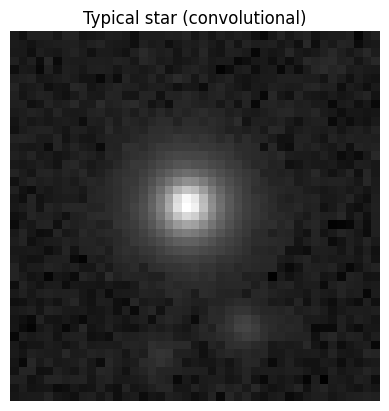

In [110]:
x=187
print(f"p(spiral,conv)={np.round(stars_df.conv_sp_prob.iat[x],5)} p(spiral,xgb)={np.round(stars_df.xgb_sp_prob.iat[x],5)}  p(spiral,per)={np.round(stars_df.per_sp_prob.iat[x],5)}")
plt.axis('off')
plt.title(f"Typical star (convolutional)")
plt.imshow(abs(stars_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

p(spiral,conv)=0.05078 p(spiral,xgb)=0.21371  p(spiral,per)=0.32954


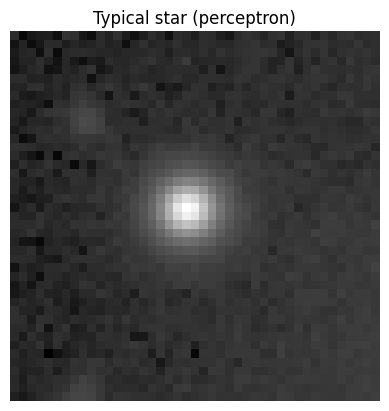

In [111]:
x=419
print(f"p(spiral,conv)={np.round(stars_df.conv_sp_prob.iat[x],5)} p(spiral,xgb)={np.round(stars_df.xgb_sp_prob.iat[x],5)}  p(spiral,per)={np.round(stars_df.per_sp_prob.iat[x],5)}")
plt.axis('off')
plt.title(f"Typical star (perceptron)")
plt.imshow(abs(stars_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

p(spiral,conv)=0.00853 p(spiral,xgb)=0.17823  p(spiral,per)=0.40566


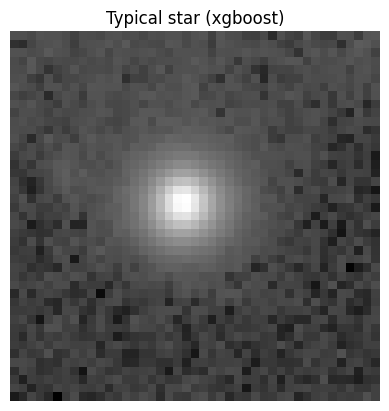

In [112]:
x=255
print(f"p(spiral,conv)={np.round(stars_df.conv_sp_prob.iat[x],5)} p(spiral,xgb)={np.round(stars_df.xgb_sp_prob.iat[x],5)}  p(spiral,per)={np.round(stars_df.per_sp_prob.iat[x],5)}")
plt.axis('off')
plt.title(f"Typical star (xgboost)")
plt.imshow(abs(stars_images[x,0,:,:])**0.125,cmap=cm.gray, interpolation='nearest')

In the images there is nearly no visible structure but still the methods besides convolutional give a relevant spiral probablity. This means they are sensisitive to very small variations, possible there was only very little variation in the training data at the location of some fluctutations.

Now I look on  the stars with the highest spiral probability starting again with convolutional. 

p(spiral,conv)=0.16569 p(spiral,xgb)=0.23796  p(spiral,per)=0.15574


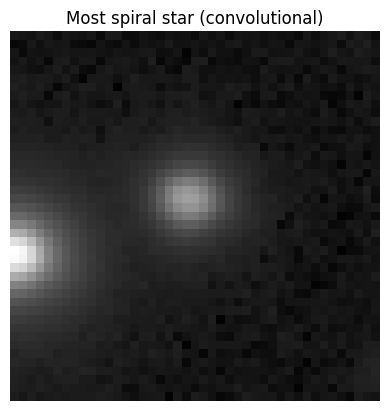

In [113]:
x=429
print(f"p(spiral,conv)={np.round(stars_df.conv_sp_prob.iat[x],5)} p(spiral,xgb)={np.round(stars_df.xgb_sp_prob.iat[x],5)}  p(spiral,per)={np.round(stars_df.per_sp_prob.iat[x],5)}")
plt.axis('off')
plt.title(f"Most spiral star (convolutional)")
plt.imshow(abs(stars_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')
#could augment data by adding stars, to it should not change the classification at 
#least then not on center and not too bright (but difficult with current data amount)

p(spiral,conv)=0.02581 p(spiral,xgb)=0.8224  p(spiral,per)=1.0


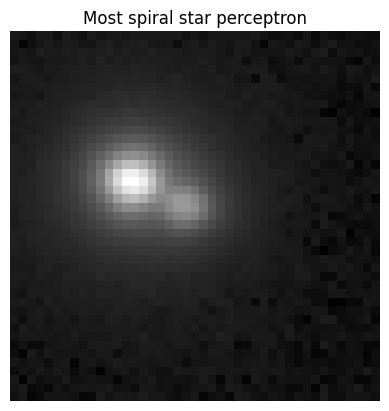

In [114]:
x=75
print(f"p(spiral,conv)={np.round(stars_df.conv_sp_prob.iat[x],5)} p(spiral,xgb)={np.round(stars_df.xgb_sp_prob.iat[x],5)}  p(spiral,per)={np.round(stars_df.per_sp_prob.iat[x],5)}")
plt.axis('off')
plt.title(f"Most spiral star perceptron")
plt.imshow(abs(stars_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')
#could augment data by adding stars, to it should not change the classification at least ehn not on center and not too bright

p(spiral,conv)=0.05125 p(spiral,xgb)=0.99448  p(spiral,per)=1.0


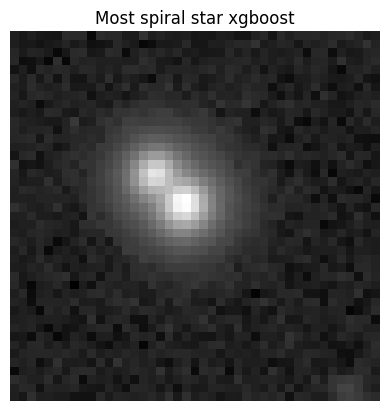

In [115]:
x=455
print(f"p(spiral,conv)={np.round(stars_df.conv_sp_prob.iat[x],5)} p(spiral,xgb)={np.round(stars_df.xgb_sp_prob.iat[x],5)}  p(spiral,per)={np.round(stars_df.per_sp_prob.iat[x],5)}")
plt.axis('off')
plt.title(f"Most spiral star xgboost")
plt.imshow(abs(stars_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')
#could augment data by adding stars, to it should not change the classification at least ehn not on center and not too bright

All these stars have a second bright source in the field, likely another star. It makes sense that they are more difficult. Clearly convolutional is less sensitive than the others, that gives confindence that the classification is not easily influenced by a second source for it. Still, it is not ideal that the stars cannot be distinguished from elliptical galaxies easily. That can be achieved by combining with the star galaxy classification or by a new multi classification model. 

### Influence of not proper centered galaxies

Next I am testing how the algorithms are influenced by non proper centering on a objects.
First I get some typical galaxies of both kinds and display some. 

median probablity for elliptical is 0.017826
median probablity for spiral is 0.999002
median spirals
17     0.999991
72     1.000000
229    0.999955
310    0.999760
Name: conv_sp_prob, dtype: float64
median ellipticals
35     0.017078
112    0.010393
116    0.001110
162    0.018574
Name: conv_sp_prob, dtype: float64


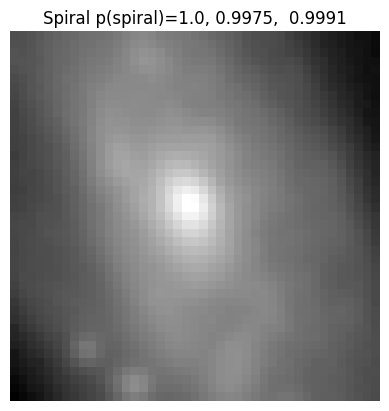

In [116]:
print(f"median probablity for elliptical is {np.round(allspec_df_el.median_sp_prob.median(),6)}")
print(f"median probablity for spiral is {np.round(allspec_df_spi.median_sp_prob.median(),6)}")
allspec_df_spimed=allspec_df_spi[(abs(allspec_df_spi.median_sp_prob-0.999)<0.0001)]
print("median spirals")
print(allspec_df_spimed.conv_sp_prob)
allspec_df_elmed=allspec_df_el[(abs(allspec_df_el.median_sp_prob-0.017826)<0.0027)]
print("median ellipticals")
print(allspec_df_elmed.conv_sp_prob)

x=17
plt.axis('off')
plt.title(f"Spiral p(spiral)={np.round(allspec_df.conv_sp_prob[x],4)}, {np.round(allspec_df.xgb_sp_prob[x],4)},  {np.round(allspec_df.per_sp_prob[x],4)}")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

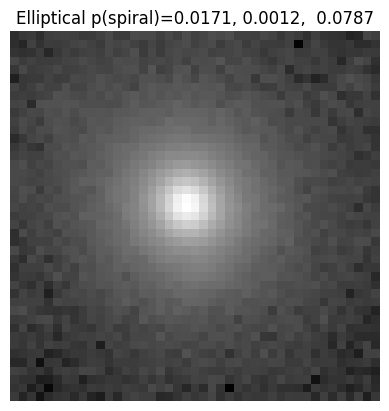

In [117]:
x=35
plt.axis('off')
plt.title(f"Elliptical p(spiral)={np.round(allspec_df.conv_sp_prob[x],4)}, {np.round(allspec_df.xgb_sp_prob[x],4)},  {np.round(allspec_df.per_sp_prob[x],4)}")
plt.imshow(abs(allspec_images[x,0,:,:])**0.25,cmap=cm.gray, interpolation='nearest')

Now I collect the data also at shifted locations. First creating a combined data frame and lists of images. 

In [118]:
#now getting tables from above and combining them 
list_df=[allspec_df_spimed,allspec_df_elmed]  
print(f"number of tables is {len(list_df)}") 
dfsel=pd.concat(list_df,ignore_index=True)

print(dfsel.columns)

path='/home/tobias/ml-testing/astr-images/'
list_input_files=[f for f in os.listdir(path) 
    if f.endswith('_rdeep.fits.gz') and os.path.isfile(os.path.join(path, f))]
list_input_files.sort()
print(list_input_files)

number of tables is 2
Index([    'Unnamed: 0',          'index',          'objid',             'ra',
                  'dec',       'psfMag_u',       'psfMag_g',       'psfMag_r',
             'psfMag_i',       'psfMag_z',
       ...
                   1844,             1845,             1846,             1847,
                   1848,    'xgb_sp_prob',   'conv_sp_prob',    'per_sp_prob',
         'mean_sp_prob', 'median_sp_prob'],
      dtype='object', length=1905)
['f0801_rdeep.fits.gz', 'f0802_rdeep.fits.gz', 'f0803_rdeep.fits.gz', 'f0804_rdeep.fits.gz', 'f0805_rdeep.fits.gz', 'f0811_rdeep.fits.gz', 'f0812_rdeep.fits.gz', 'f0813_rdeep.fits.gz', 'f0814_rdeep.fits.gz', 'f0815_rdeep.fits.gz', 'f0821_rdeep.fits.gz', 'f0822_rdeep.fits.gz', 'f0823_rdeep.fits.gz', 'f0824_rdeep.fits.gz', 'f0825_rdeep.fits.gz', 'f0831_rdeep.fits.gz', 'f0832_rdeep.fits.gz', 'f0833_rdeep.fits.gz', 'f0834_rdeep.fits.gz', 'f0835_rdeep.fits.gz', 'f0841_rdeep.fits.gz', 'f0842_rdeep.fits.gz', 'f0843_rdeep.fits.gz',

Now I get the shifted images and assocaited data frames. I try shifts of to 24 pixels, that is slightly larger than the half box radius of 21.5, thus on the most extreme cases the center of galaxies is missing fully. 

In [119]:
cutout_shift1,df_shift1=shifted_cutouts(dfsel,list_input_files,offsets=30)

number of tables is 30
Index([   'Unnamed: 0',         'index',         'objid',            'ra',
                 'dec',      'psfMag_u',      'psfMag_g',      'psfMag_r',
            'psfMag_i',      'psfMag_z',     'probPSF_u',     'probPSF_g',
           'probPSF_r',     'probPSF_i',     'probPSF_z',    'modelMag_u',
          'modelMag_g',    'modelMag_r',    'modelMag_i',    'modelMag_z',
          'petroRad_g',    'petroRad_r',    'petroRad_i',           'run',
               'rerun',        'camcol',         'field',          'type',
           'specobjid',         'class',      'subclass',      'redshift',
               'plate',           'mjd',       'fiberid',         'nvote',
                'p_el',          'p_cw',         'p_acw',        'p_edge',
                'p_dk',          'p_mg', 'p_el_debiased', 'p_cs_debiased',
              'spiral',    'elliptical',     'uncertain',         'image',
             'pixel_x',       'pixel_y',     'off_image',               0],
 

Below I show a unshifted Spiral galaxy. 

(240, 54) (8, 1905) (43, 43, 1, 240)


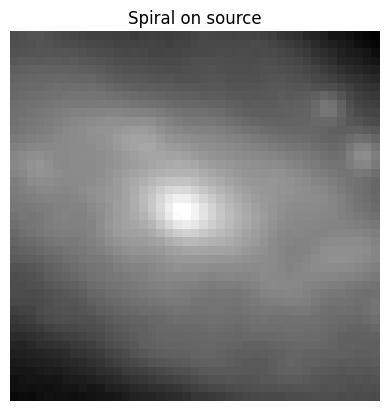

In [120]:
print(df_shift1.shape,dfsel.shape,cutout_shift1.shape)
x=0
plt.axis('off')
plt.title(f"Spiral on source")
plt.imshow(abs(cutout_shift1[:,:,0,x])**0.25,cmap=cm.gray, interpolation='nearest')

Below I show the maximum shift applied. 

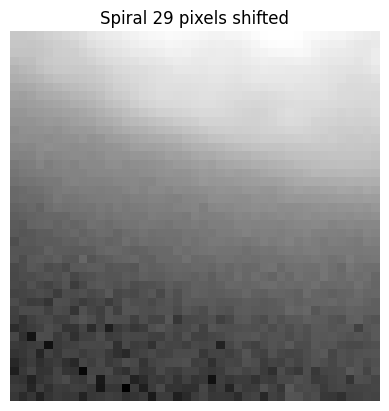

In [121]:

x=29
plt.axis('off')
plt.title(f"Spiral {x} pixels shifted")
plt.imshow(abs(cutout_shift1[:,:,0,x])**0.25,cmap=cm.gray, interpolation='nearest')
#saving the files needed, since next function can only work on sved files
np.save("stripe82_shifted_sel1_im.npy",cutout_shift1)    
df_shift1.to_csv('stripe82_shifted_sel1_table.csv') 

Now I apply the classfications methods on it. 

In [122]:
#image and classes
images_shifted=['stripe82_shifted_sel1_im.npy']
classes_shifted=['stripe82_shifted_sel1_table.csv']
#getting for all  3 models
shift_cpred,shift_df,shift_images=predict_probs(images_shifted,classes_shifted,'conv2d_2layers_reg0.0001_rotmir_240epochs_v0.pkl',modelname='convolutional',keep_prob=1)
#problem with less columns in frame here should be improved possible backwards defintion of columns
shift_xpred=predict_probs(images_shifted,classes_shifted,'xgboost_model_spiral_ell_rot_mirr_l2reg3.json',modelname='xgboost',image_output=False,df_output=False)
shift_ppred=predict_probs(images_shifted,classes_shifted,'mlp_4layers_reg0.003_rotmir_200epochs_v0.pkl',modelname='perceptron',num_features=1849,image_output=False,df_output=False)
shift_df['xgb_sp_prob']=shift_xpred
shift_df['conv_sp_prob']=shift_cpred
shift_df['per_sp_prob']=shift_ppred
shift_df['mean_sp_prob']=shift_df[['per_sp_prob','conv_sp_prob','xgb_sp_prob']].mean(axis=1)
shift_df['median_sp_prob']=shift_df[['per_sp_prob','conv_sp_prob','xgb_sp_prob']].median(axis=1)

(240, 1, 43, 43)
number of tables is 1
shape of combined data frame (240, 55)
shape of image file is (240, 1, 43, 43)
(240, 1904)
Index(['Unnamed: 0.1',      'level_0',   'Unnamed: 0',        'index',
              'objid',           'ra',          'dec',     'psfMag_u',
           'psfMag_g',     'psfMag_r',
       ...
                 1839,           1840,           1841,           1842,
                 1843,           1844,           1845,           1846,
                 1847,           1848],
      dtype='object', length=1904)
Index(['Unnamed: 0.1', 'level_0', 'Unnamed: 0', 'index', 'objid', 'ra', 'dec',
       'psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i', 'psfMag_z', 'probPSF_u',
       'probPSF_g', 'probPSF_r', 'probPSF_i', 'probPSF_z', 'modelMag_u',
       'modelMag_g', 'modelMag_r', 'modelMag_i', 'modelMag_z', 'petroRad_g',
       'petroRad_r', 'petroRad_i', 'run', 'rerun', 'camcol', 'field', 'type',
       'specobjid', 'class', 'subclass', 'redshift', 'plate', 'mjd', 'fibe

169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239


Now I am looking on the probablities for these shifted cutout images, first the spiral galaxies. 

0    421
1    184
2    165
3    340
4    592
5    164
6    501
7    548
Name: index, dtype: int64


Text(0, 0.5, 'Spiral probability')

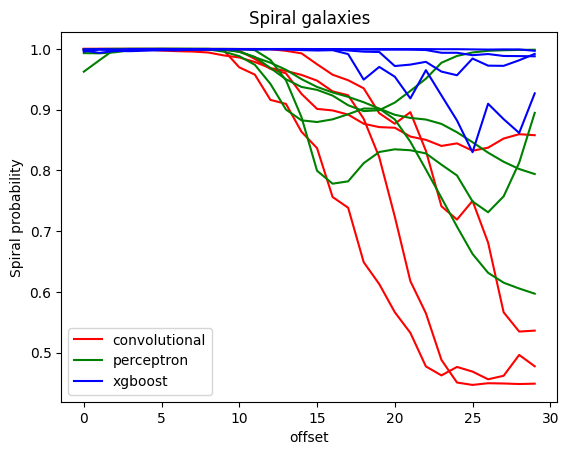

In [123]:
print(dfsel['index'])
shift_df1=shift_df[(shift_df['index']==421)]
shift_df2=shift_df[(shift_df['index']==184)]
shift_df3=shift_df[(shift_df['index']==165)]
shift_df4=shift_df[(shift_df['index']==340)]
shift_df5=shift_df[(shift_df['index']==592)]
shift_df6=shift_df[(shift_df['index']==164)]
shift_df7=shift_df[(shift_df['index']==501)]
shift_df8=shift_df[(shift_df['index']==548)]
plt.plot(shift_df1['offset'],shift_df1['conv_sp_prob'],label='convolutional',color='red')
plt.plot(shift_df2['offset'],shift_df2['conv_sp_prob'],color='red')
plt.plot(shift_df3['offset'],shift_df3['conv_sp_prob'],color='red')
plt.plot(shift_df4['offset'],shift_df4['conv_sp_prob'],color='red')
plt.plot(shift_df1['offset'],shift_df1['per_sp_prob'],label='perceptron',color='green')
plt.plot(shift_df2['offset'],shift_df2['per_sp_prob'],color='green')
plt.plot(shift_df3['offset'],shift_df3['per_sp_prob'],color='green')
plt.plot(shift_df4['offset'],shift_df4['per_sp_prob'],color='green')
plt.plot(shift_df1['offset'],shift_df1['xgb_sp_prob'],label='xgboost',color='blue')
plt.plot(shift_df2['offset'],shift_df2['xgb_sp_prob'],color='blue')
plt.plot(shift_df3['offset'],shift_df3['xgb_sp_prob'],color='blue')
plt.plot(shift_df4['offset'],shift_df4['xgb_sp_prob'],color='blue')
plt.legend(loc="best")
plt.xlabel('offset')
plt.title('Spiral galaxies')
plt.ylabel('Spiral probability')
#plt.ylim(0.88,0.965)

The probablity stays rather high for most cases. However since it is the main class, 73% of all are this class, it is expected that the probality is about that even for not well working classfication. The probabilty is lowest for convolutional, possible indicating that this methods finds not much structure in the outskirts and thus classfies the galaxies as elliptical.

Next the same for elliptical. 

Text(0, 0.5, 'Spiral probability')

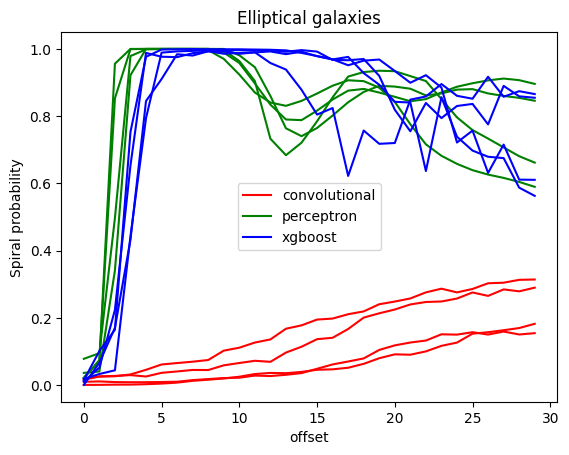

In [124]:
plt.plot(shift_df5['offset'],shift_df5['conv_sp_prob'],label='convolutional',color='red')
plt.plot(shift_df6['offset'],shift_df6['conv_sp_prob'],color='red')
plt.plot(shift_df7['offset'],shift_df7['conv_sp_prob'],color='red')
plt.plot(shift_df8['offset'],shift_df8['conv_sp_prob'],color='red')
plt.plot(shift_df5['offset'],shift_df5['per_sp_prob'],label='perceptron',color='green')
plt.plot(shift_df6['offset'],shift_df6['per_sp_prob'],color='green')
plt.plot(shift_df7['offset'],shift_df7['per_sp_prob'],color='green')
plt.plot(shift_df8['offset'],shift_df8['per_sp_prob'],color='green')
plt.plot(shift_df5['offset'],shift_df5['xgb_sp_prob'],label='xgboost',color='blue')
plt.plot(shift_df6['offset'],shift_df6['xgb_sp_prob'],color='blue')
plt.plot(shift_df7['offset'],shift_df7['xgb_sp_prob'],color='blue')
plt.plot(shift_df8['offset'],shift_df8['xgb_sp_prob'],color='blue')
plt.legend(loc="best")
plt.xlabel('offset')
plt.title('Elliptical galaxies')
plt.ylabel('Spiral probability')

For elliptical galaxies, the spiral probability is low for rather larger offsets for convolutional, even when the center is off the image for 29 pixels, while perceptron and xgbboost only get the right classfication for rather tiny offsets.
Thus convolutional works much better when the center is offset from the true center.

This behaviour is expected since convoltional consider the image structure and can find the features in other parts of images as it is fitted on, while the other consider on which pixels the structure is on the training images. 

## Conclusions

Overall, I find that a rather good galaxy image classification is surprsingly easy, even method which are not designed for images work rather well when images are well centered. The reason is that galaxies have usually a much better defined center than images of for example cats and dogs have. Without good centering convoltional works better as expected. 

The classfication is not perfect, but perfection is also difficult in this cases because there are relatively many border line cases for which the type cannot be agrred even for experts. Still some improvement is possible and is best implemented together with introducing a class for stars.  
Image areas devoid should be excluded. p_cs_debiased, p_el_debiased can be used to exclude disputed ones, possible togther with visual inspection of those cases. Another aspect is overlapping sources. This is less a problem than usual because the sky is more empty than images on earth, but still it can be problem. First such cases should be indentified. Either those sources should excluded or their neighbor should be masked. Final a first iteration can be used to excluded uncertain cases further, best after inspection.

Another aspect is application on other image data. Code should be developed to get the cutouts, when galaxies are too large, it is likely best to combine several pixels. On the other hand the noise level should also be considered in applying the methods on other data.  